In [1]:
from __future__ import print_function
import datetime
import time
from functools import reduce
from collections import defaultdict
import os
import tqdm
import gzip
import pickle

import pyarrow.parquet as parquet
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.backends.backend_pdf import PdfPages
import numba

from fastset import FastSet

In [2]:
#   DBS BLOCKS table schema:
#     BLOCK_ID NOT NULL NUMBER(38)
#     BLOCK_NAME NOT NULL VARCHAR2(500)
#     DATASET_ID NOT NULL NUMBER(38)
#     OPEN_FOR_WRITING NOT NULL NUMBER(38)
#     ORIGIN_SITE_NAME NOT NULL VARCHAR2(100)
#     BLOCK_SIZE NUMBER(38)
#     FILE_COUNT NUMBER(38)
#     CREATION_DATE NUMBER(38)
#     CREATE_BY VARCHAR2(500)
#     LAST_MODIFICATION_DATE NUMBER(38)
#     LAST_MODIFIED_BY VARCHAR2(500)
if not os.path.exists('data/block_size.npy'):
    # numpy readcsv couldn't handle the size :(
    blocksize = pd.read_csv("data/dbs_blocks.csv", dtype='i8', usecols=(0,5), names=['block_id', 'block_size'])
    np.save('data/block_size.npy', blocksize.values)
    blocksize = blocksize.values
else:
    blocksize = np.load('data/block_size.npy')

# We'll be accessing randomly, make a fast lookup
bsort = np.argsort(blocksize[:,0])
bsize_index = FastSet(blocksize[bsort, 0])
bsize_values = blocksize[bsort, 1]
bsize_values = np.append(bsize_values, 0)
def getsize(s):
    return bsize_values[np.searchsorted(bsize_index._set, s._set)].sum()

In [3]:
blockmap_filename = 'data/blockmap.pkl'
if not os.path.exists(blockmap_filename):
    blockmap_in = pd.read_csv("data/dbs_blocks.csv", dtype='i8', usecols=(0,2), names=['block_id', 'dataset_id'])
    blockmap = defaultdict(FastSet)
    for bid, dsid in blockmap_in.values:
        blockmap[dsid] += FastSet([bid])

    del blockmap_in
    with gzip.open(blockmap_filename, 'wb') as fout:
        pickle.dump(blockmap, fout)
else:
    with gzip.open(blockmap_filename) as fin:
        blockmap = pickle.load(fin)

In [4]:
ws_cmssw = parquet.read_table('data/working_set_cmssw').to_pandas()
ws_cmssw['working_set_blocks'] = ws_cmssw.apply(lambda x: FastSet(x.working_set_blocks), 'columns')
ws_cmssw = ws_cmssw[ws_cmssw.site_name.str.startswith(('T3'))==False]
ws_cmssw = ws_cmssw[ws_cmssw.site_name.str.startswith(('T0'))==False]
ws_cmssw['site_name'] = ws_cmssw['site_name'].str.replace(r'_DISK$', '', regex=False)
ws_cmssw['site_name'] = ws_cmssw.site_name.apply(lambda s: s + '_Disk' if ((s.startswith('T1')==True) 
                                                                           & (s.endswith('Disk')==False)) else s) 

ws_cmssw_local = ws_cmssw[ws_cmssw.is_local==True]

In [5]:
ws_fwjr = parquet.read_table('data/working_set_fwjr').to_pandas()
ws_fwjr['working_set_blocks'] = ws_fwjr.apply(lambda x: FastSet(x.working_set_blocks), 'columns')
ws_fwjr = ws_fwjr[ws_fwjr.site_name.str.startswith(('T3'))==False]
ws_fwjr = ws_fwjr[ws_fwjr.site_name.str.startswith(('T0'))==False]
ws_fwjr['site_name'] = ws_fwjr['site_name'].str.replace(r'_DISK$', '', regex=False)
ws_fwjr['site_name'] = ws_fwjr.site_name.apply(lambda s: s + '_Disk' if ((s.startswith('T1')==True) 
                                                                         & (s.endswith('Disk')==False)) else s) 

In [6]:
# join the data tier definitions
titles = ['id', 'data_tier', 'day', 'user']
datatiers = pd.read_csv('data/dbs_datatiers.csv', names=titles).set_index('id')

def add_datatiers(ws):
    ws['data_tier'] = datatiers.loc[ws.d_data_tier_id].data_tier.values
    
add_datatiers(ws_cmssw)
add_datatiers(ws_fwjr)

In [7]:
def aod(ws):
    return ws[ws['data_tier'].str.match('(|MINI|NANO)AOD')]

In [8]:
def mini(ws):
    return ws[ws['data_tier'].str.match('MINIAOD')]

In [9]:
def crab(ws):
    return ws.loc[ws['is_crab'] == True]

In [10]:
def dataByLoc(ws):
    data = ws.groupby('site_name').working_set_blocks.agg(lambda series: 
                                                          reduce(FastSet.union, series, 
                                                                 FastSet())).map(getsize)/1e15
    return(data)

In [11]:
def plot(suffix, title, axis, leg):
    ax = globals()['full' + suffix].plot.bar(rot=90, figsize=(30, 16), 
                                             width=0.9, color=['blue', 'orange'],
                                             edgecolor = "black", stacked=True)
    ax.set_ylabel(axis, fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.set_title("Data Use by Site%s" % title, fontsize=32)
    ax.xaxis.label.set_visible(False)
    if leg==True:
        ax.legend(prop={'size': 22})
    else: 
        ax.get_legend().remove()
    plt.gcf().subplots_adjust(bottom=0.2, left=0.1)
    plt.savefig('plots/no_filter/sites%s.pdf' % suffix)
    pp.savefig()
    

In [12]:
cmssw_set = dataByLoc(ws_cmssw).rename('CMSSW')
fwjr_set = dataByLoc(ws_fwjr).rename('FWJR')

cmssw_set_crab = dataByLoc(crab(ws_cmssw)).rename('CMSSW')

cmssw_set_aod = dataByLoc(aod(ws_cmssw)).rename('CMSSW')
fwjr_set_aod = dataByLoc(aod(ws_fwjr)).rename('FWJR')

cmssw_set_mini = dataByLoc(mini(ws_cmssw)).rename('CMSSW')
fwjr_set_mini = dataByLoc(mini(ws_fwjr)).rename('FWJR')

cmssw_set_aod_crab = dataByLoc(aod(crab(ws_cmssw))).rename('CMSSW')

cmssw_set_mini_crab = dataByLoc(mini(crab(ws_cmssw))).rename('CMSSW')

In [13]:
full = pd.concat([cmssw_set.to_frame(), fwjr_set.to_frame()], axis=1)
full_crab = cmssw_set_crab.to_frame()
full_aod = pd.concat([cmssw_set_aod.to_frame(), fwjr_set_aod.to_frame()], axis=1)
full_mini = pd.concat([cmssw_set_mini.to_frame(), fwjr_set_mini.to_frame()], axis=1)
full_aod_crab = cmssw_set_aod_crab.to_frame()
full_mini_crab = cmssw_set_mini_crab.to_frame()

full_nano = full_aod - full_mini
full_nano_crab = full_aod_crab - full_mini_crab

In [14]:
totals = pd.read_pickle('https://ncsmith.web.cern.ch/ncsmith/phedex2rucio/rucio_summary.pkl.gz')
totals = totals.drop('Total')

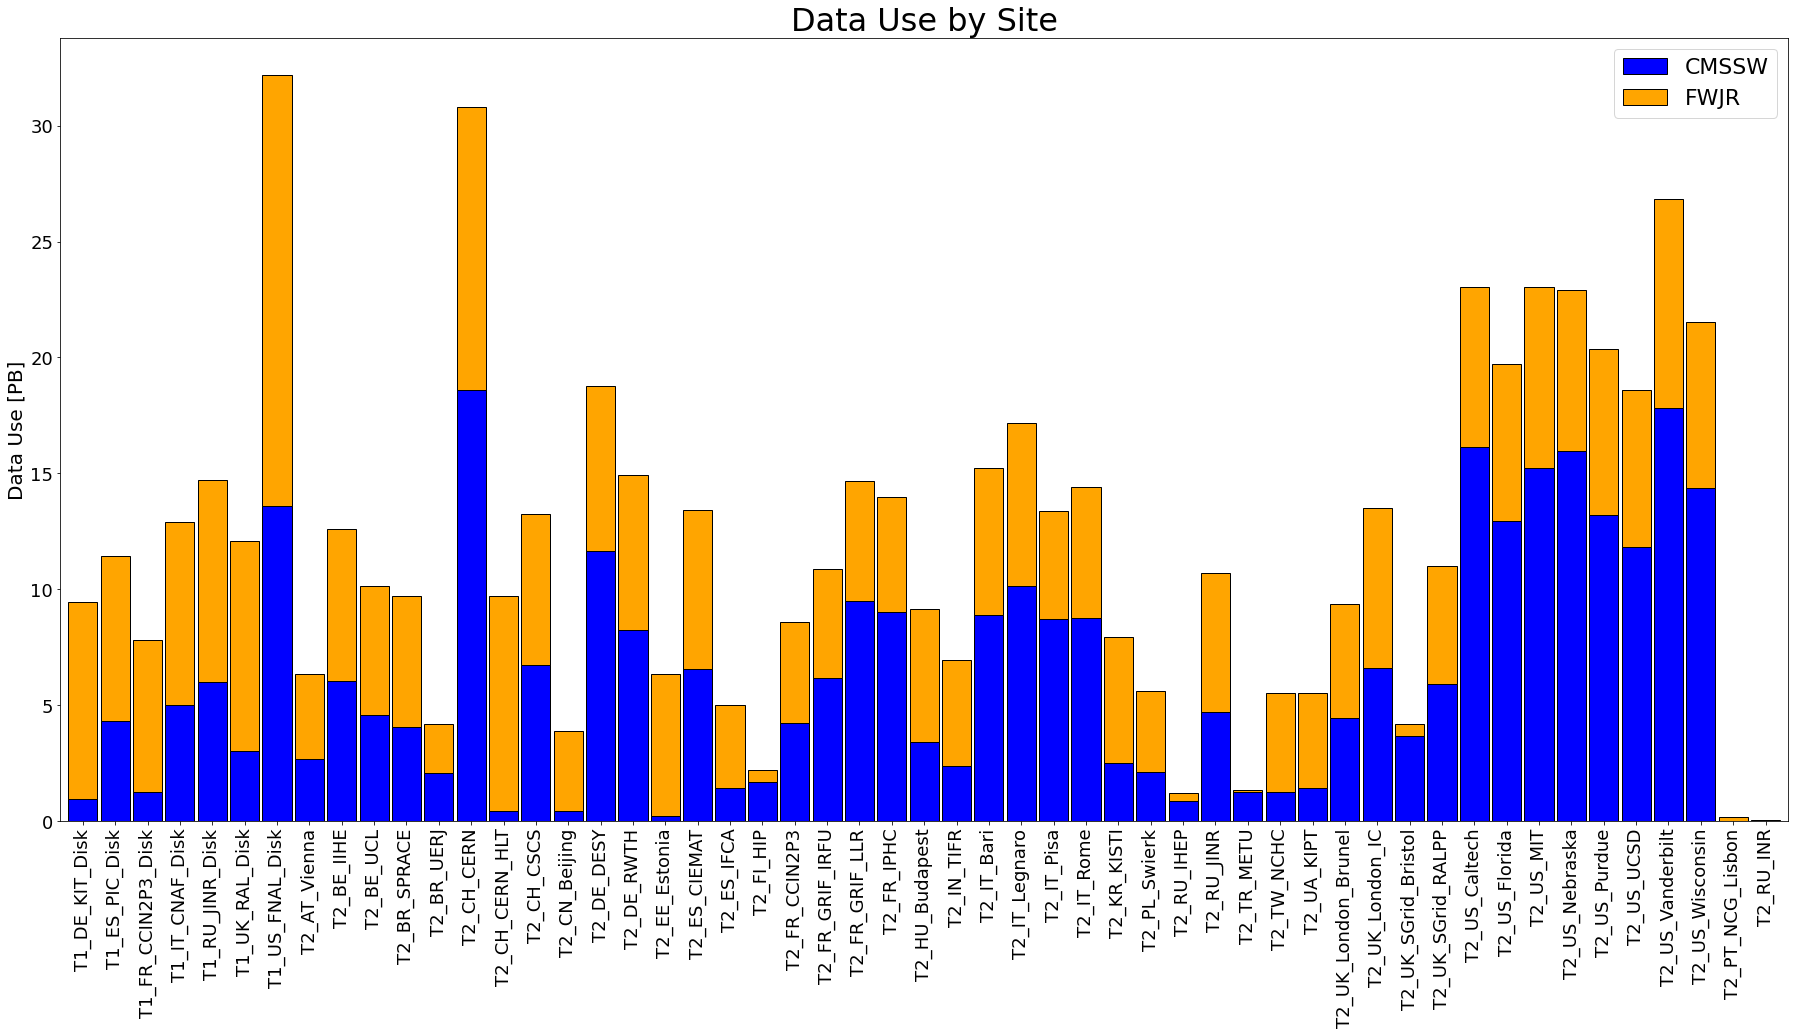

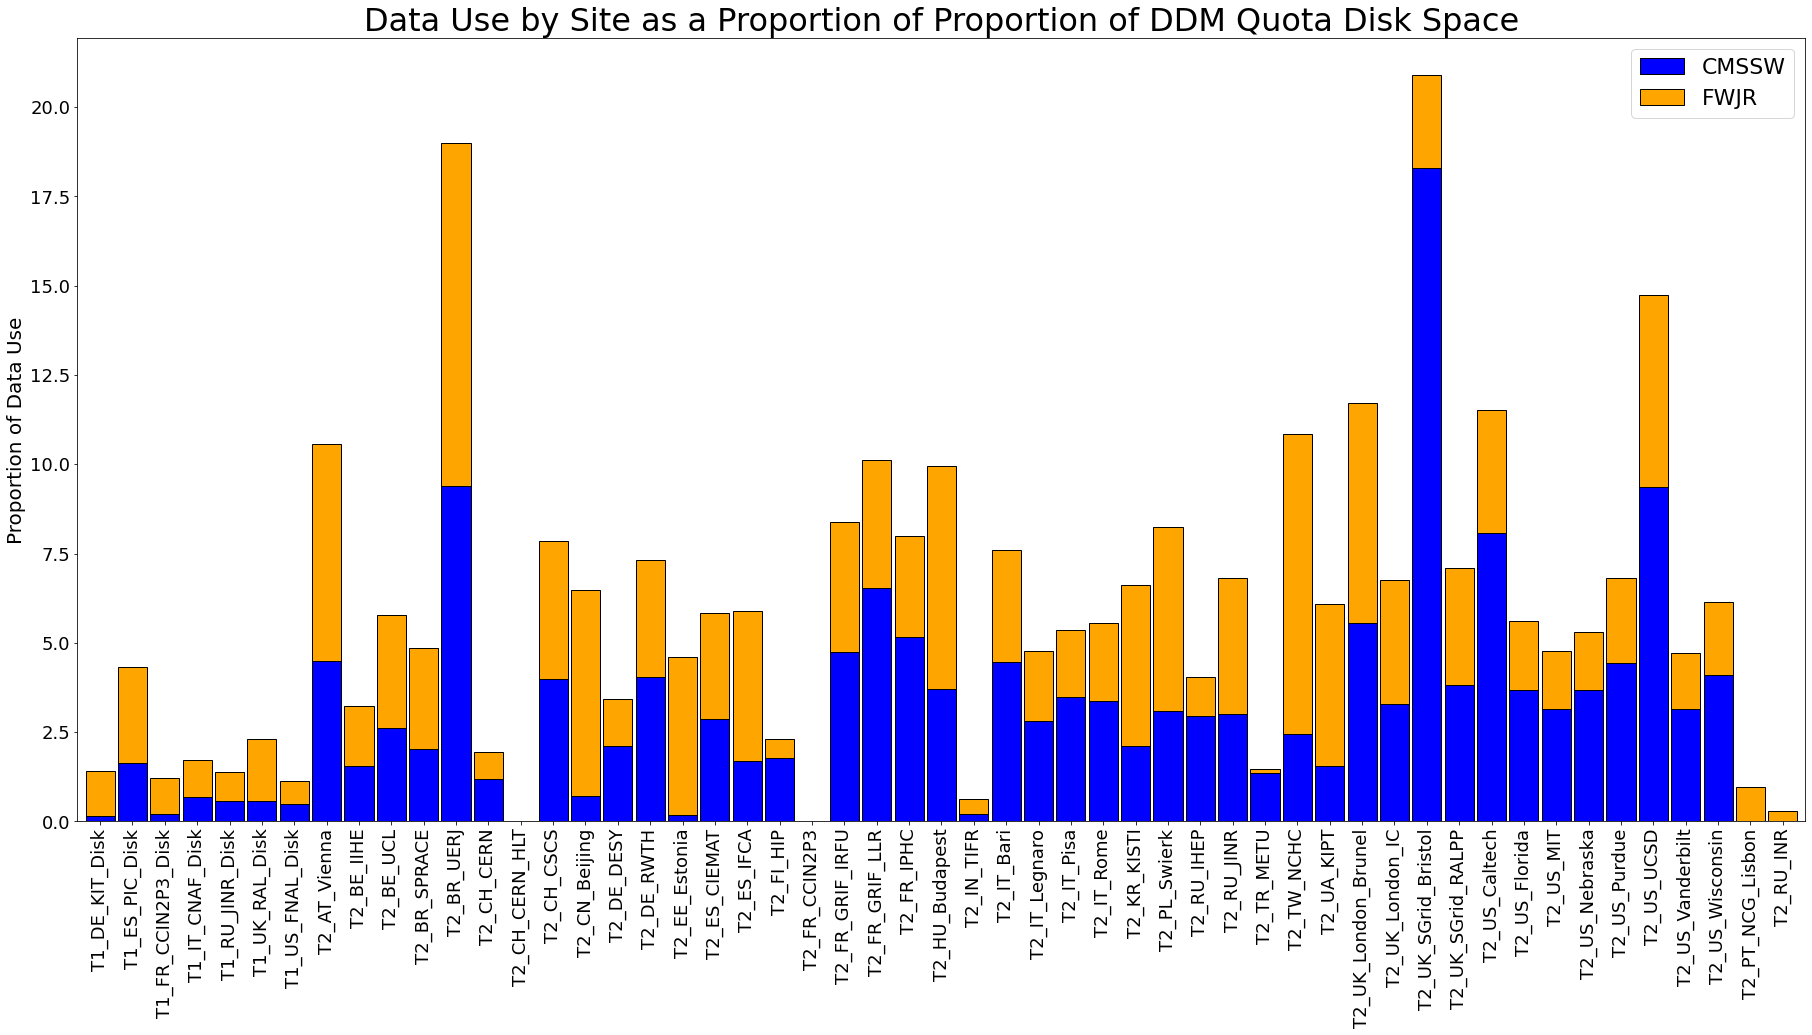

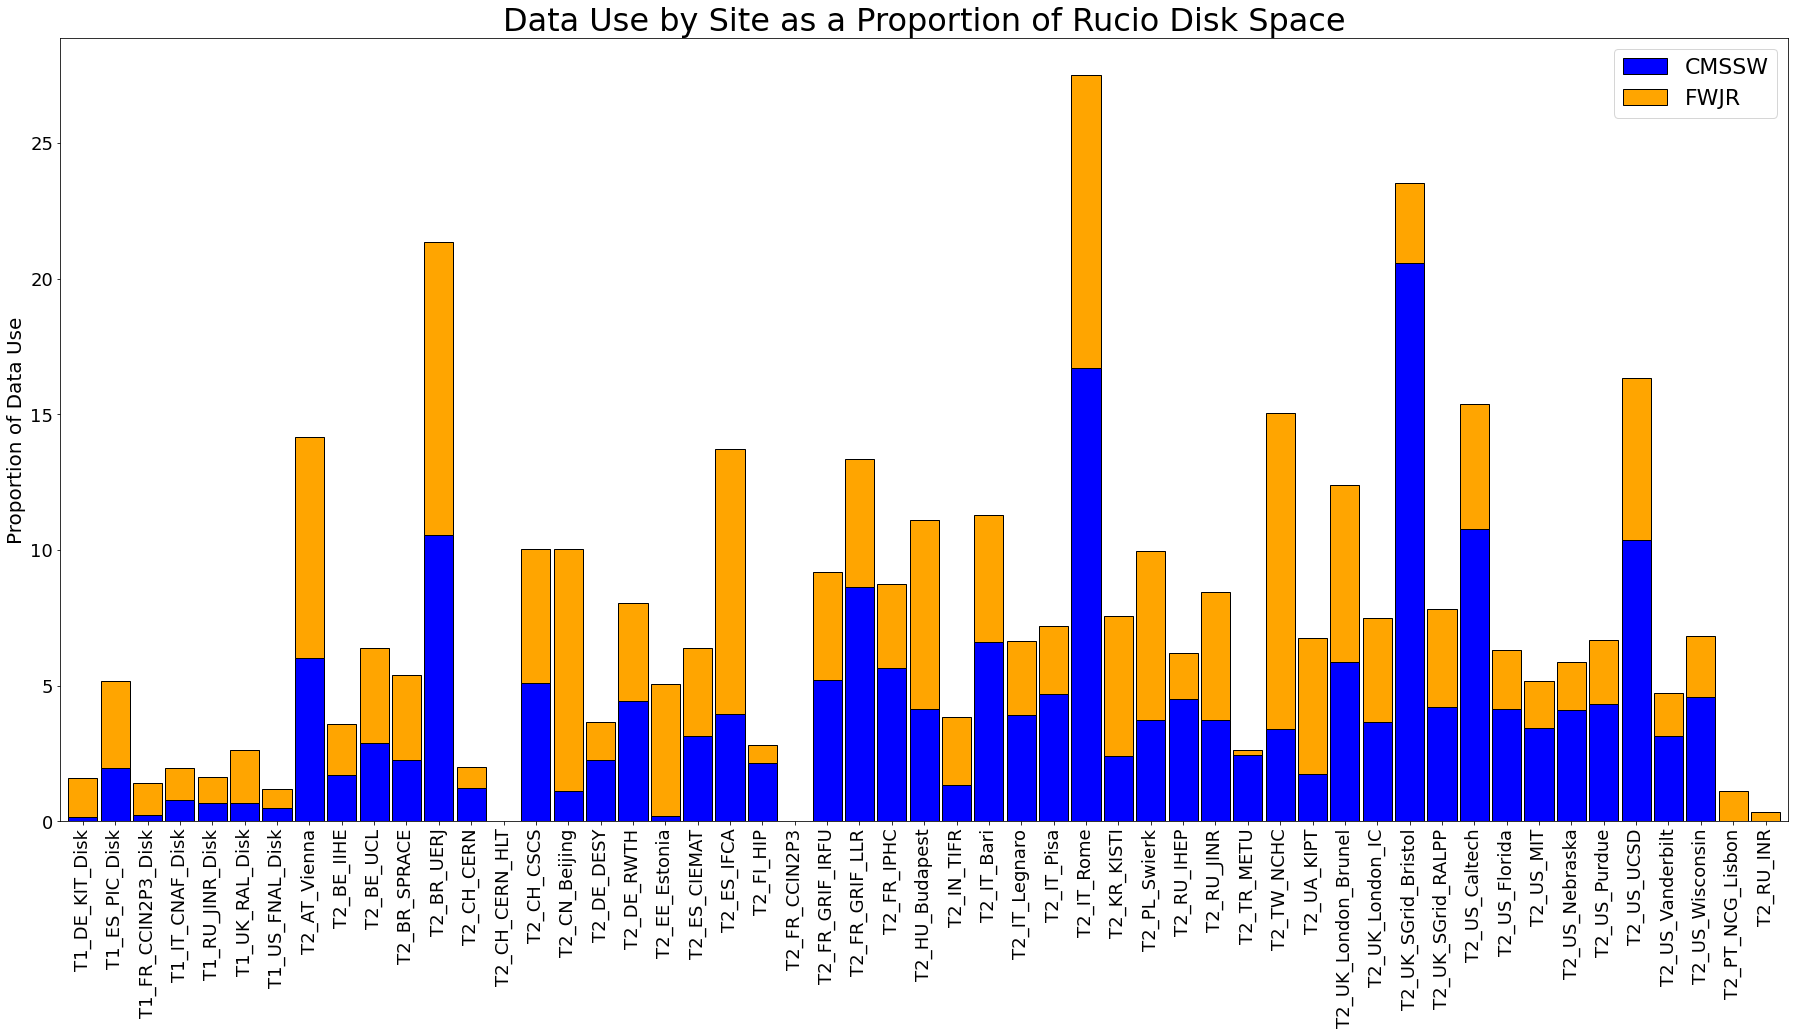

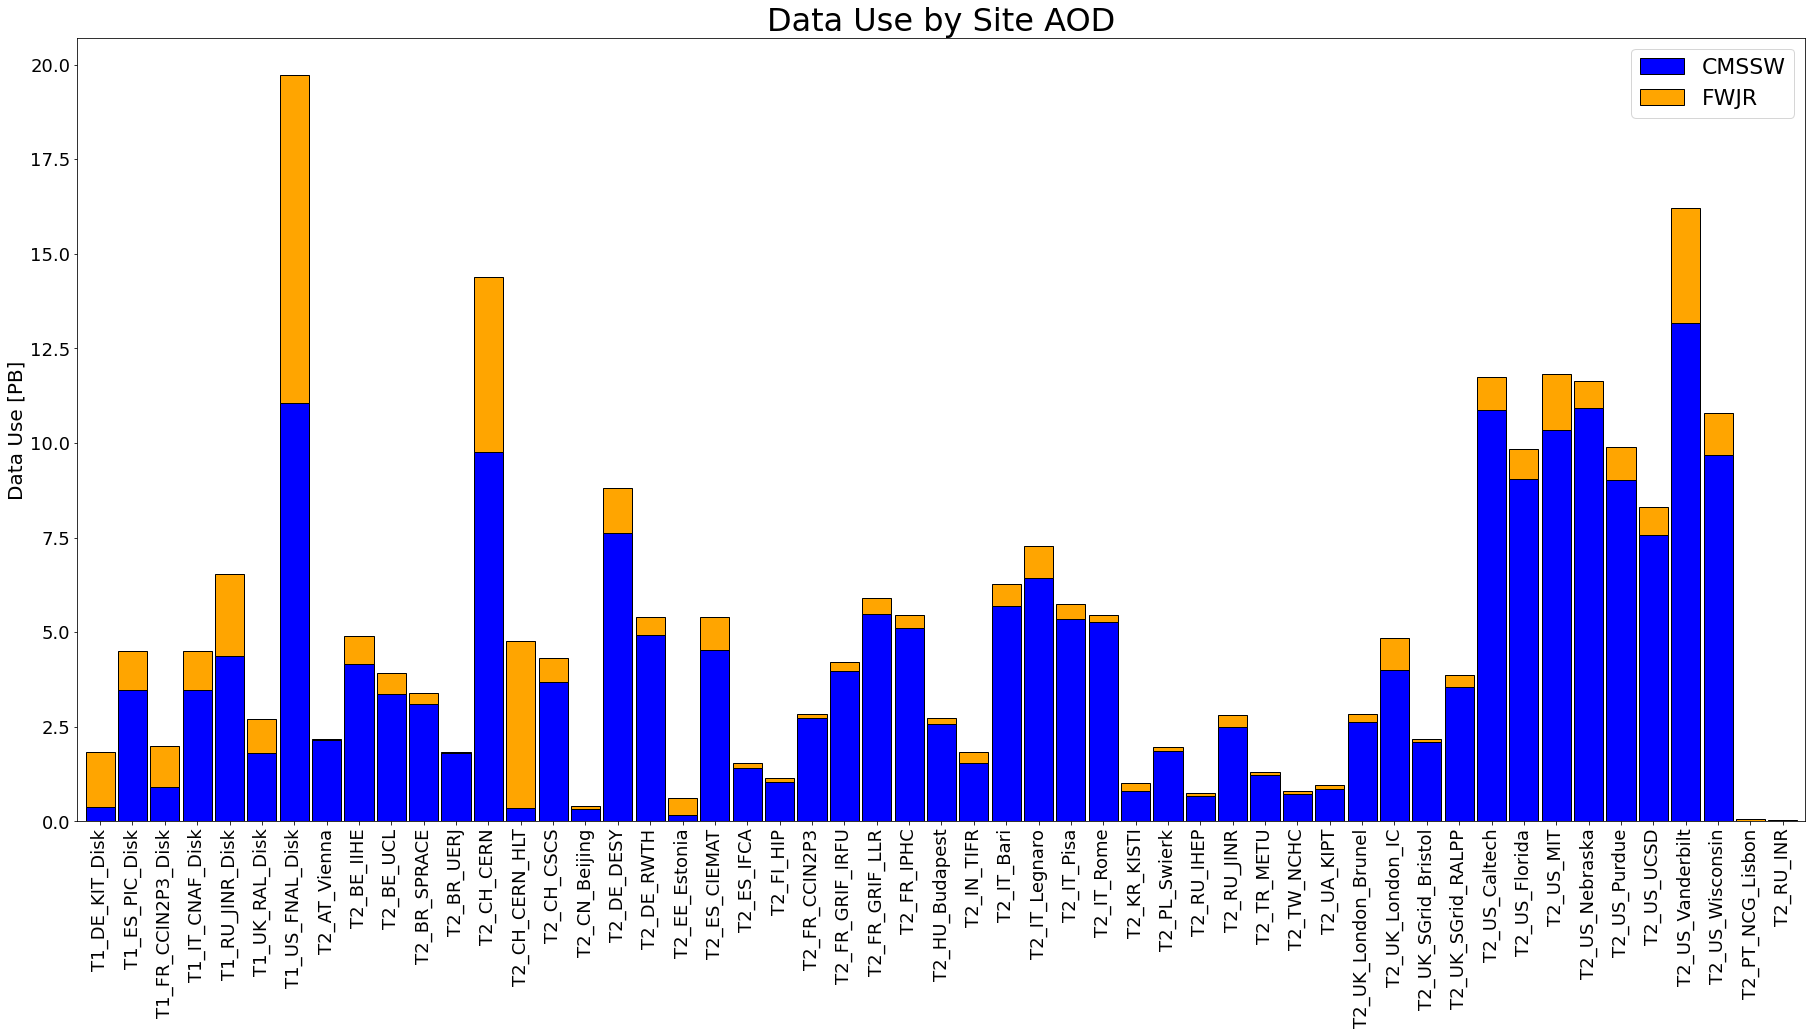

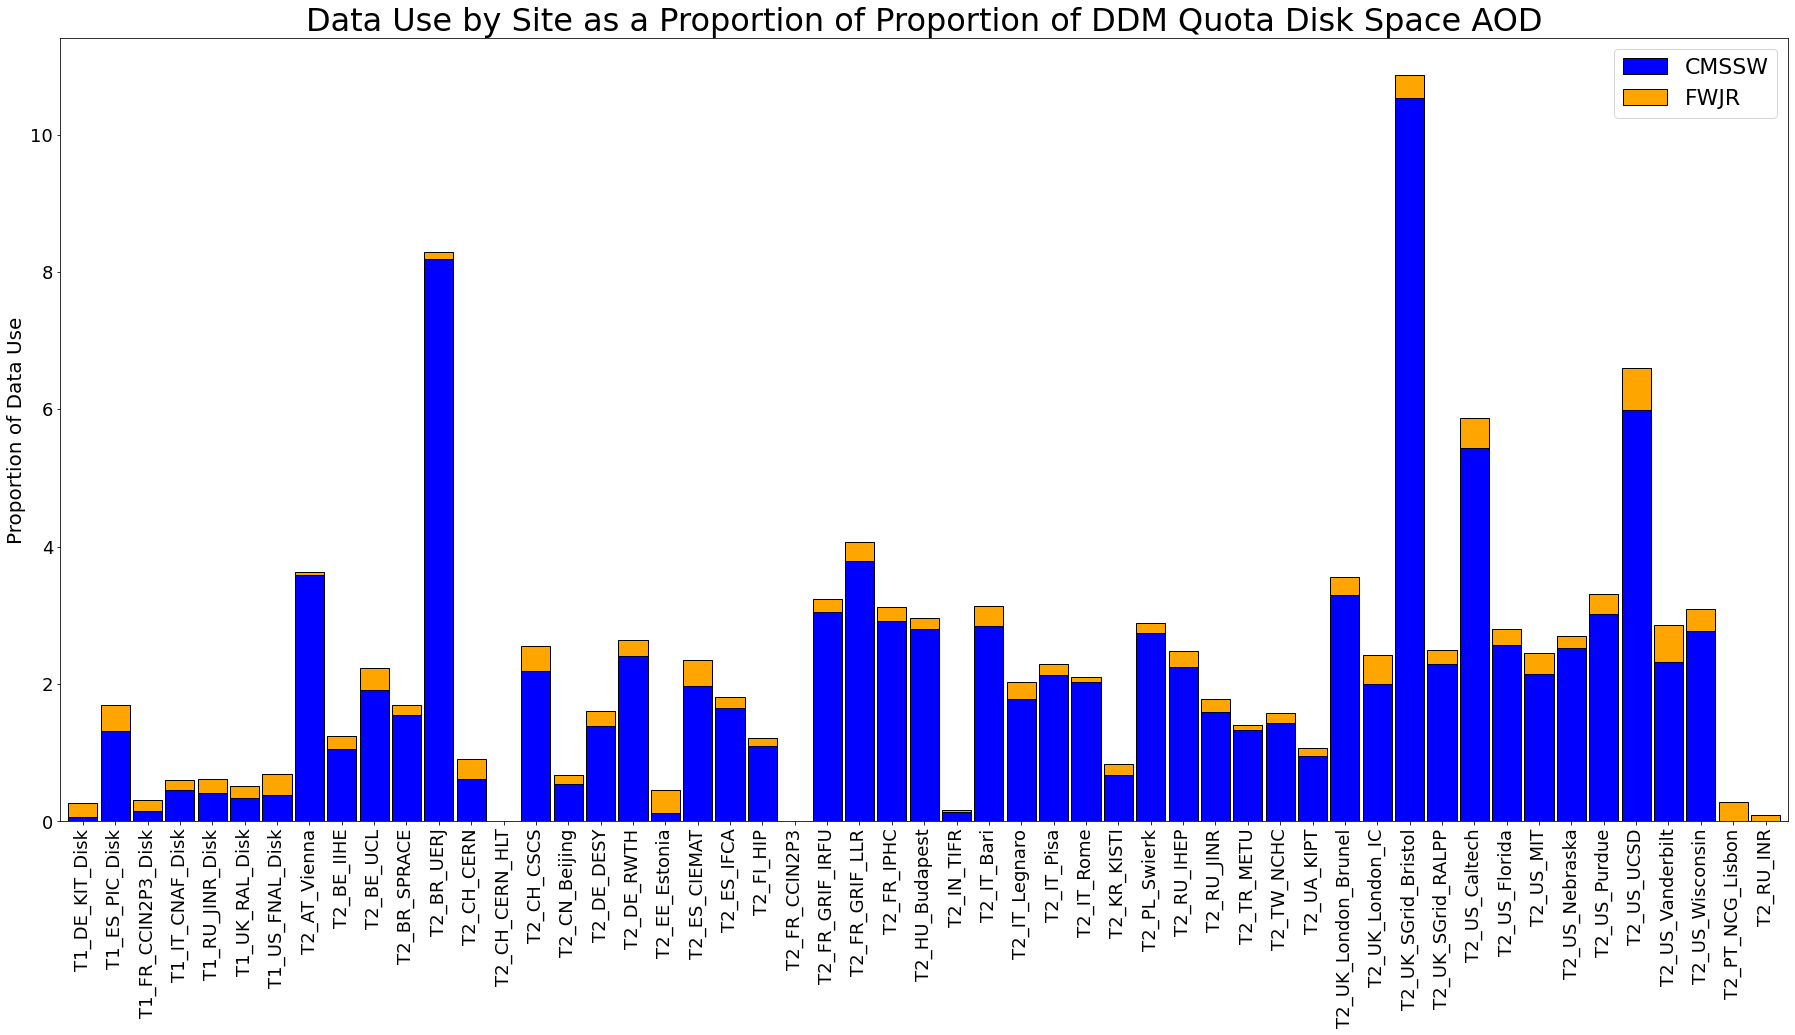

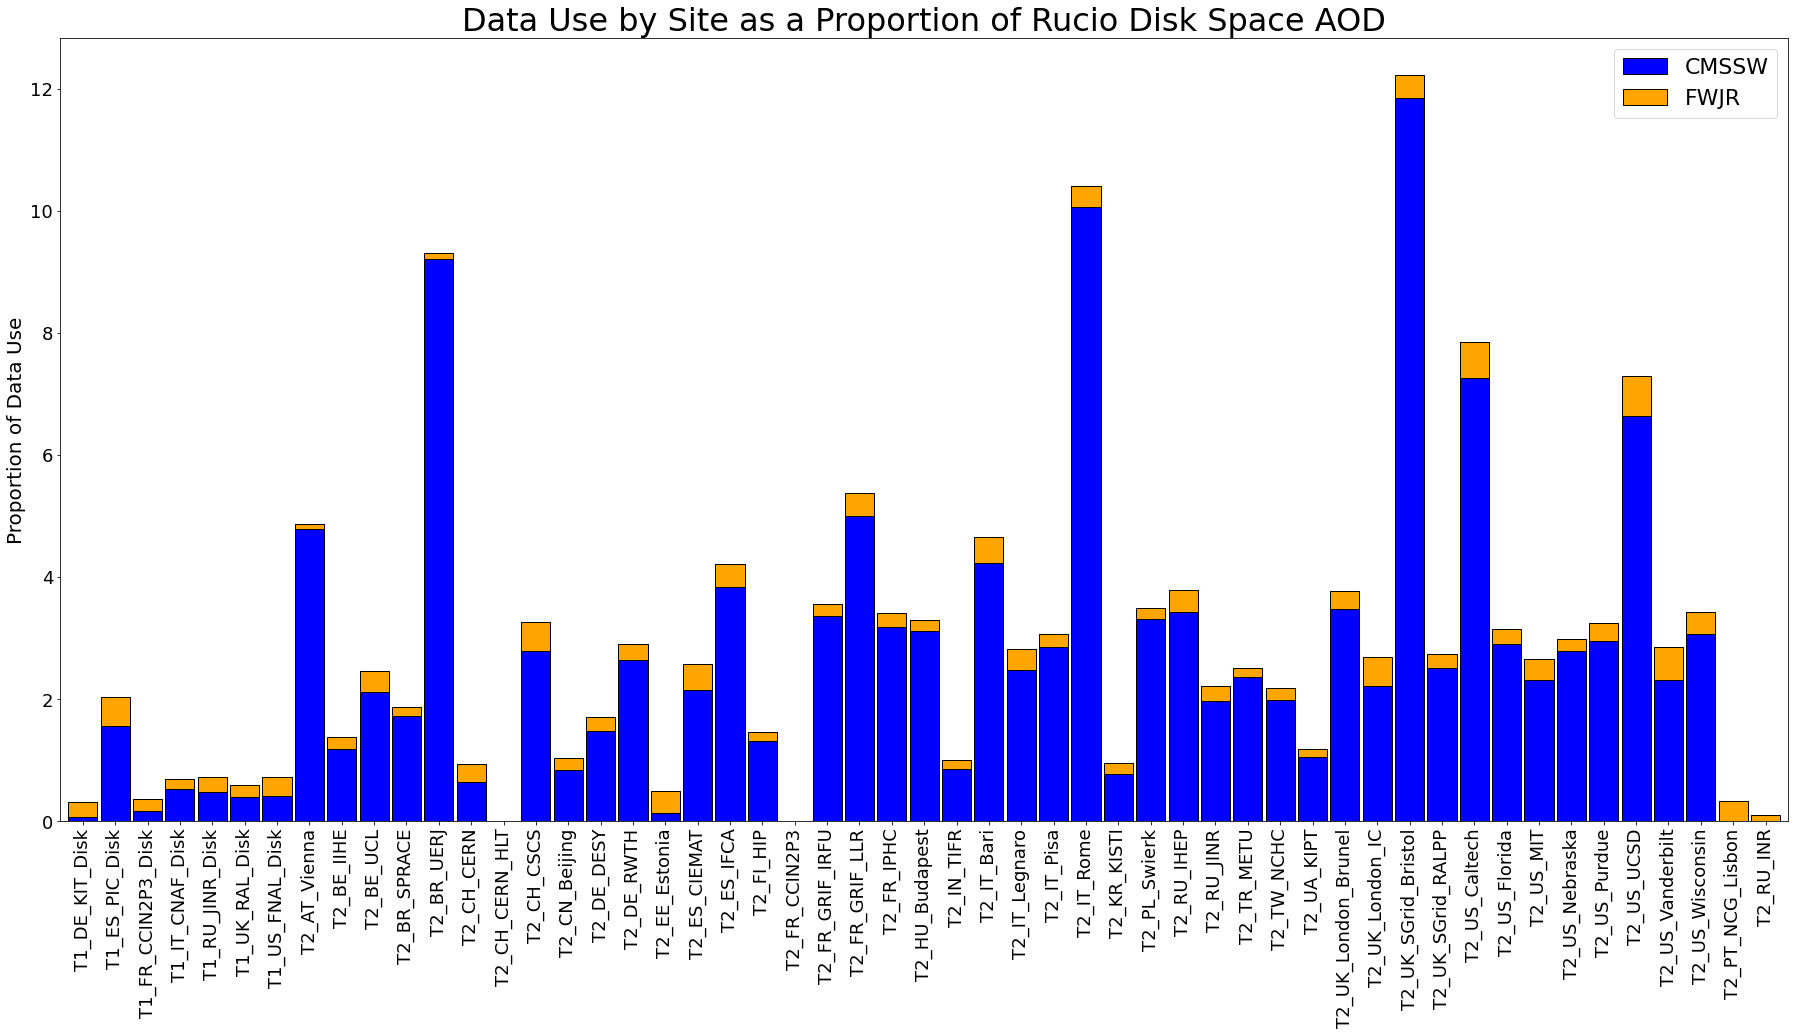

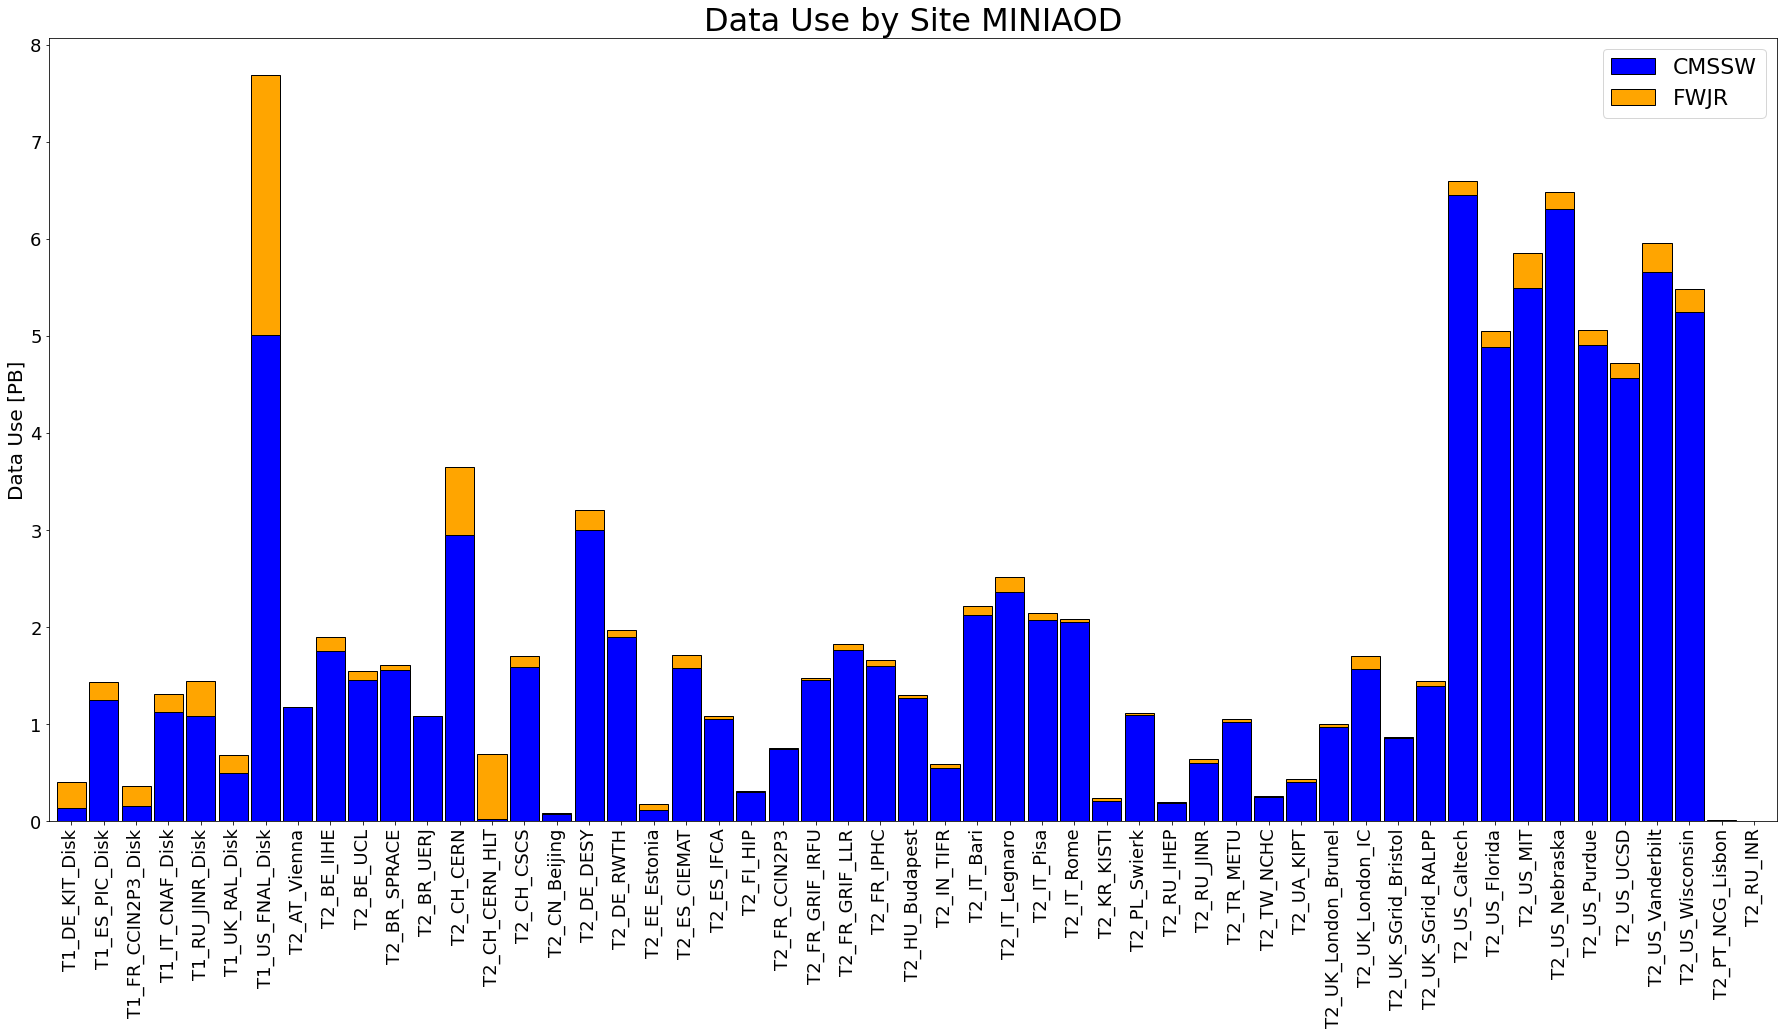

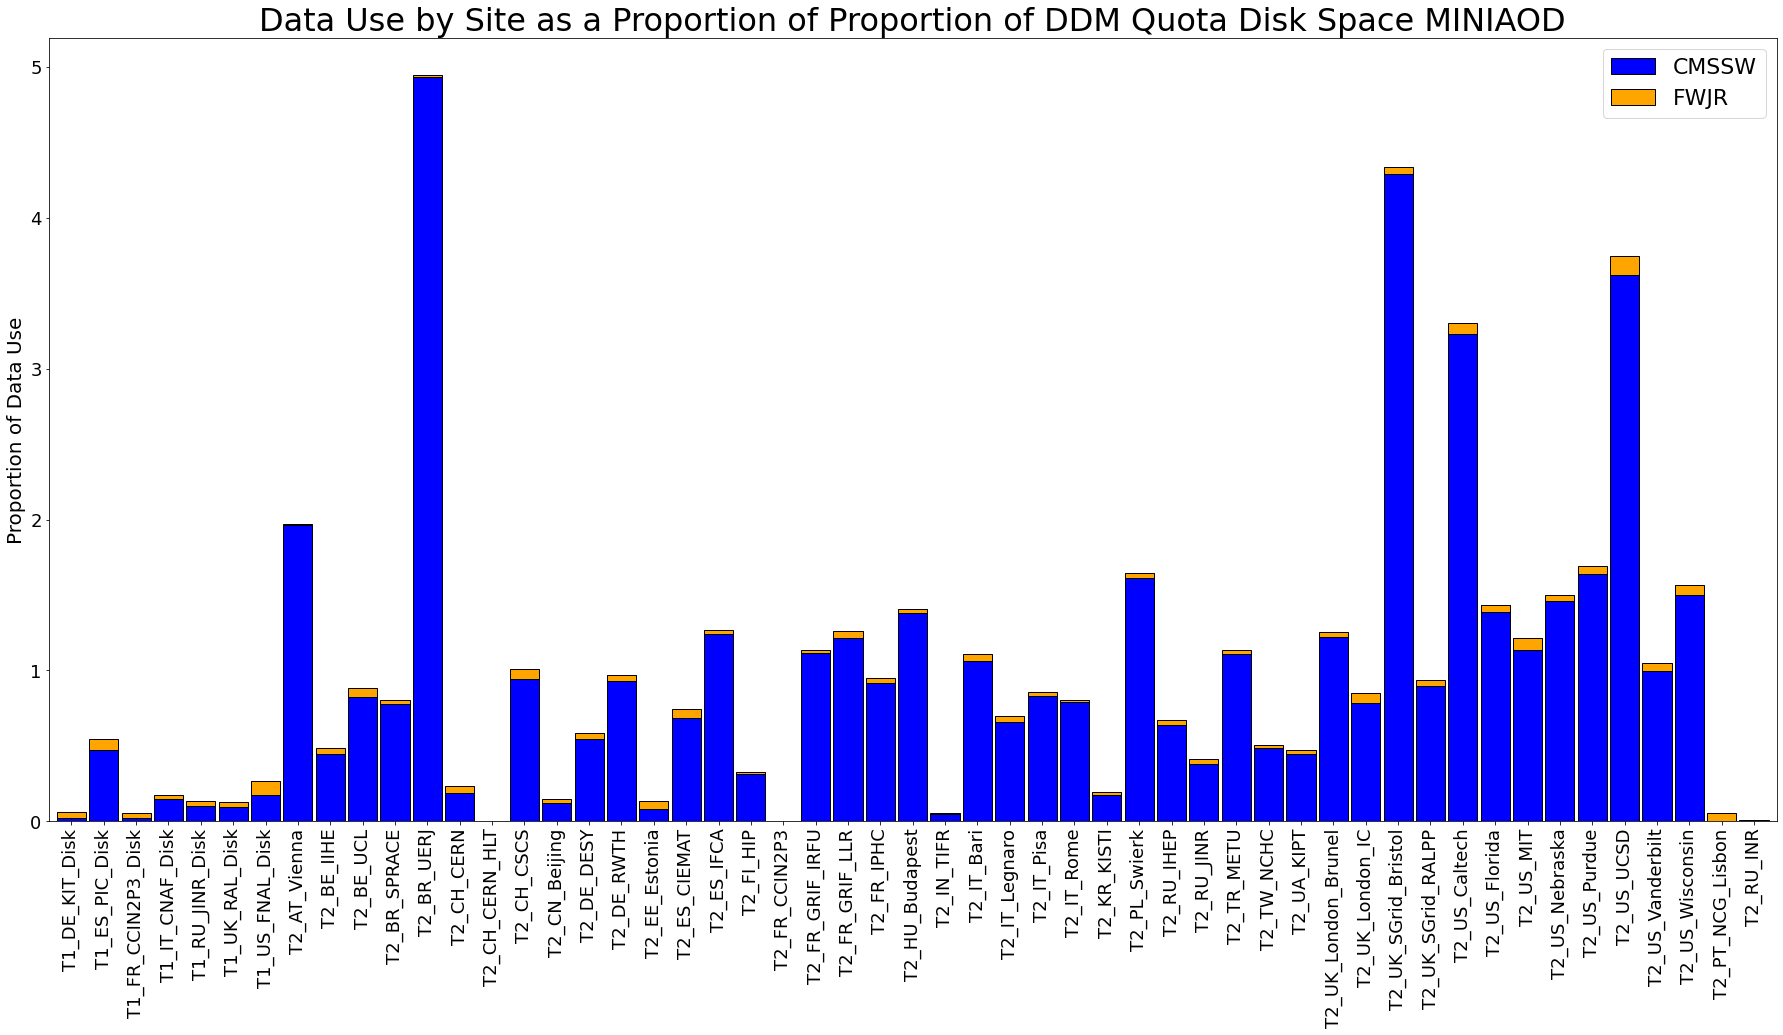

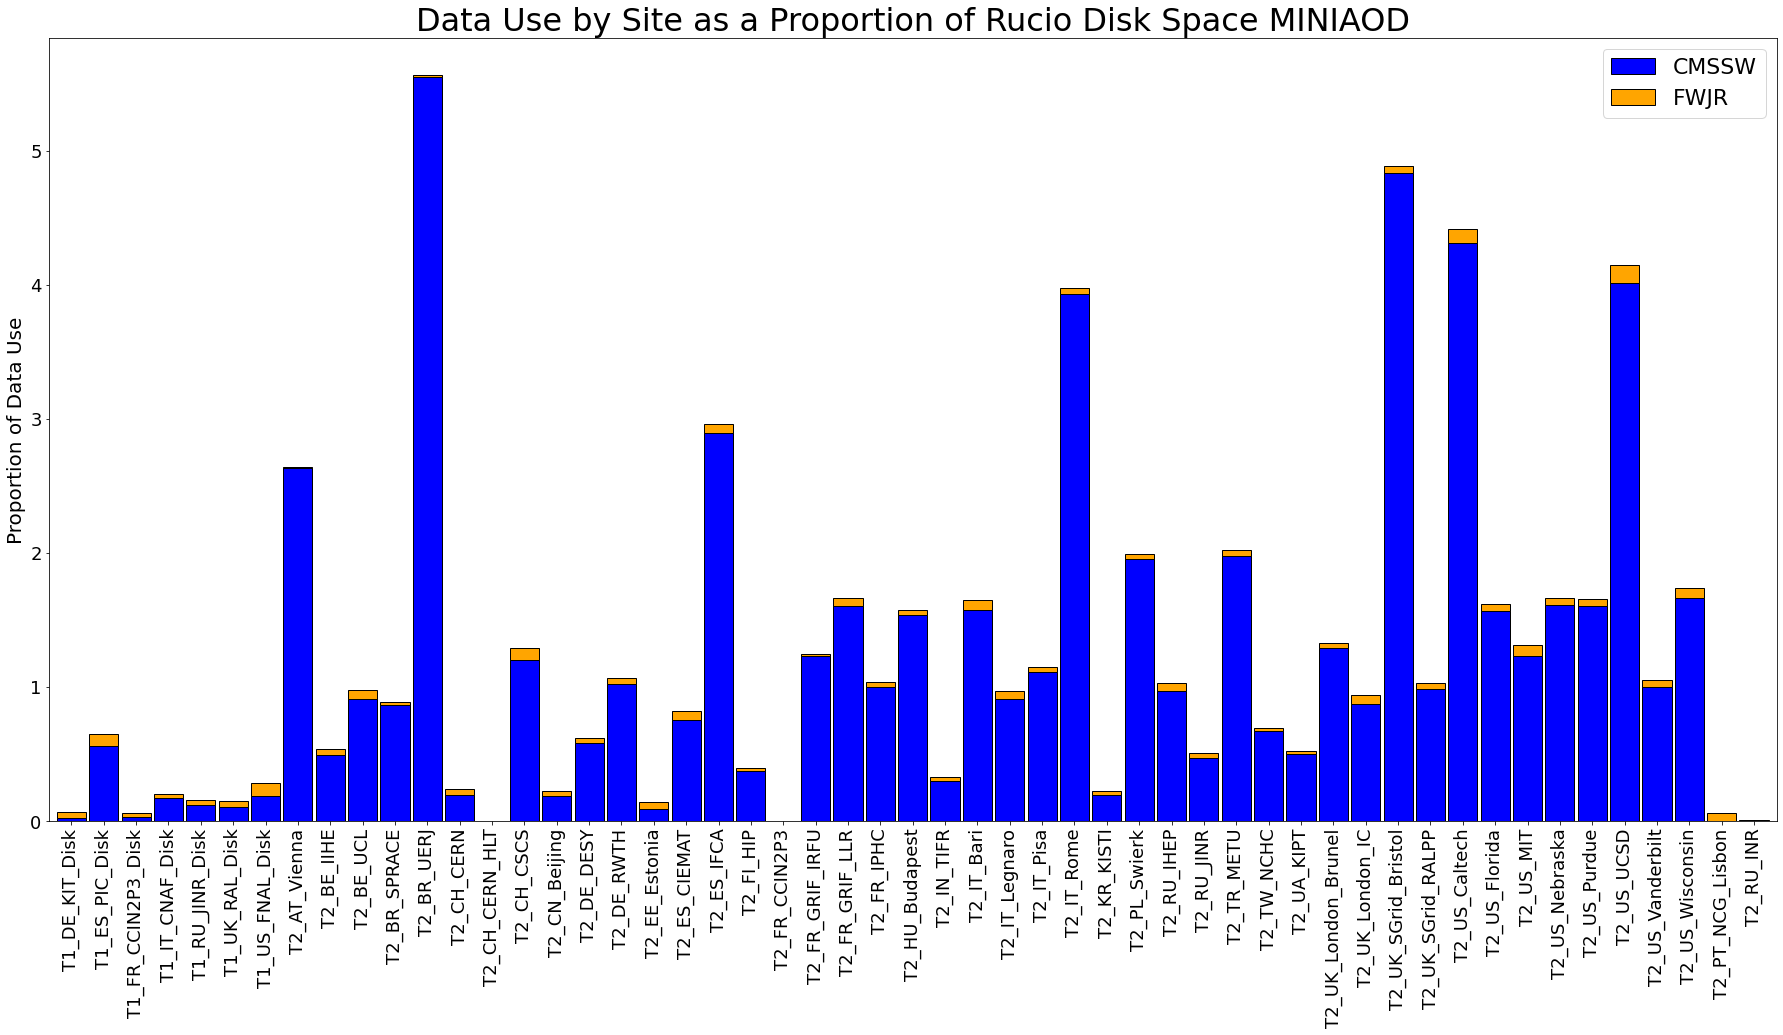

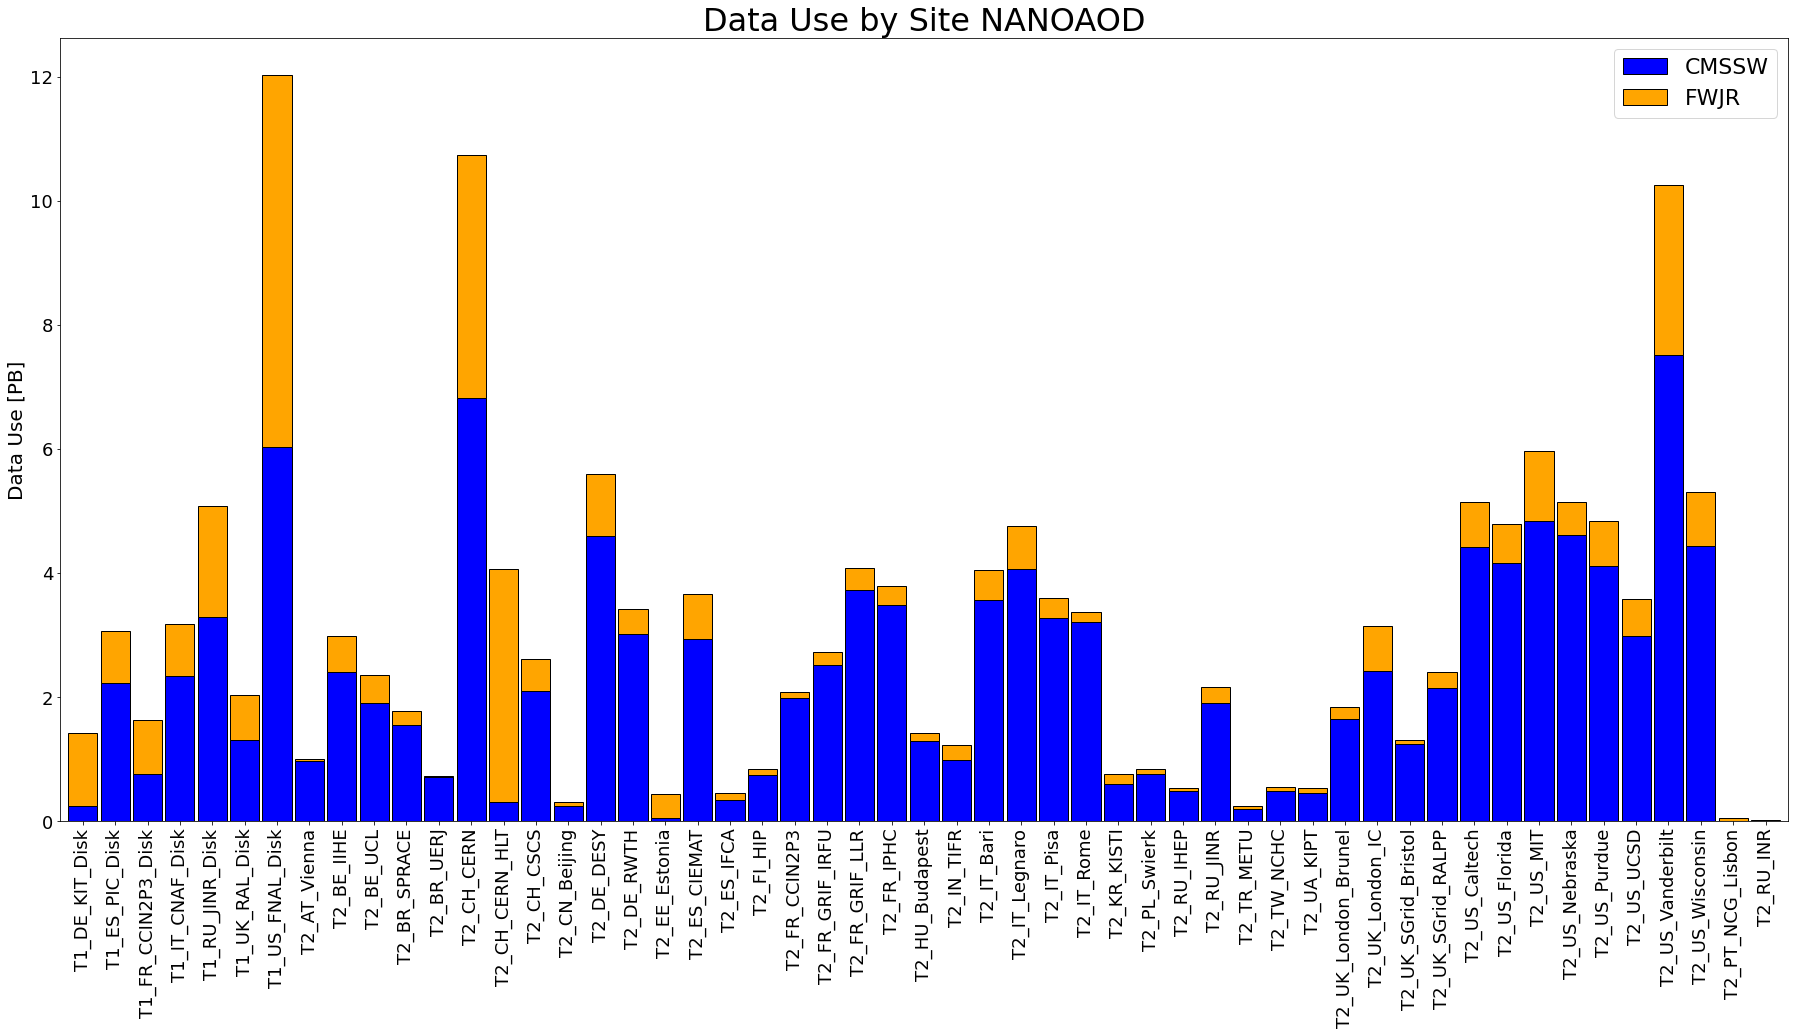

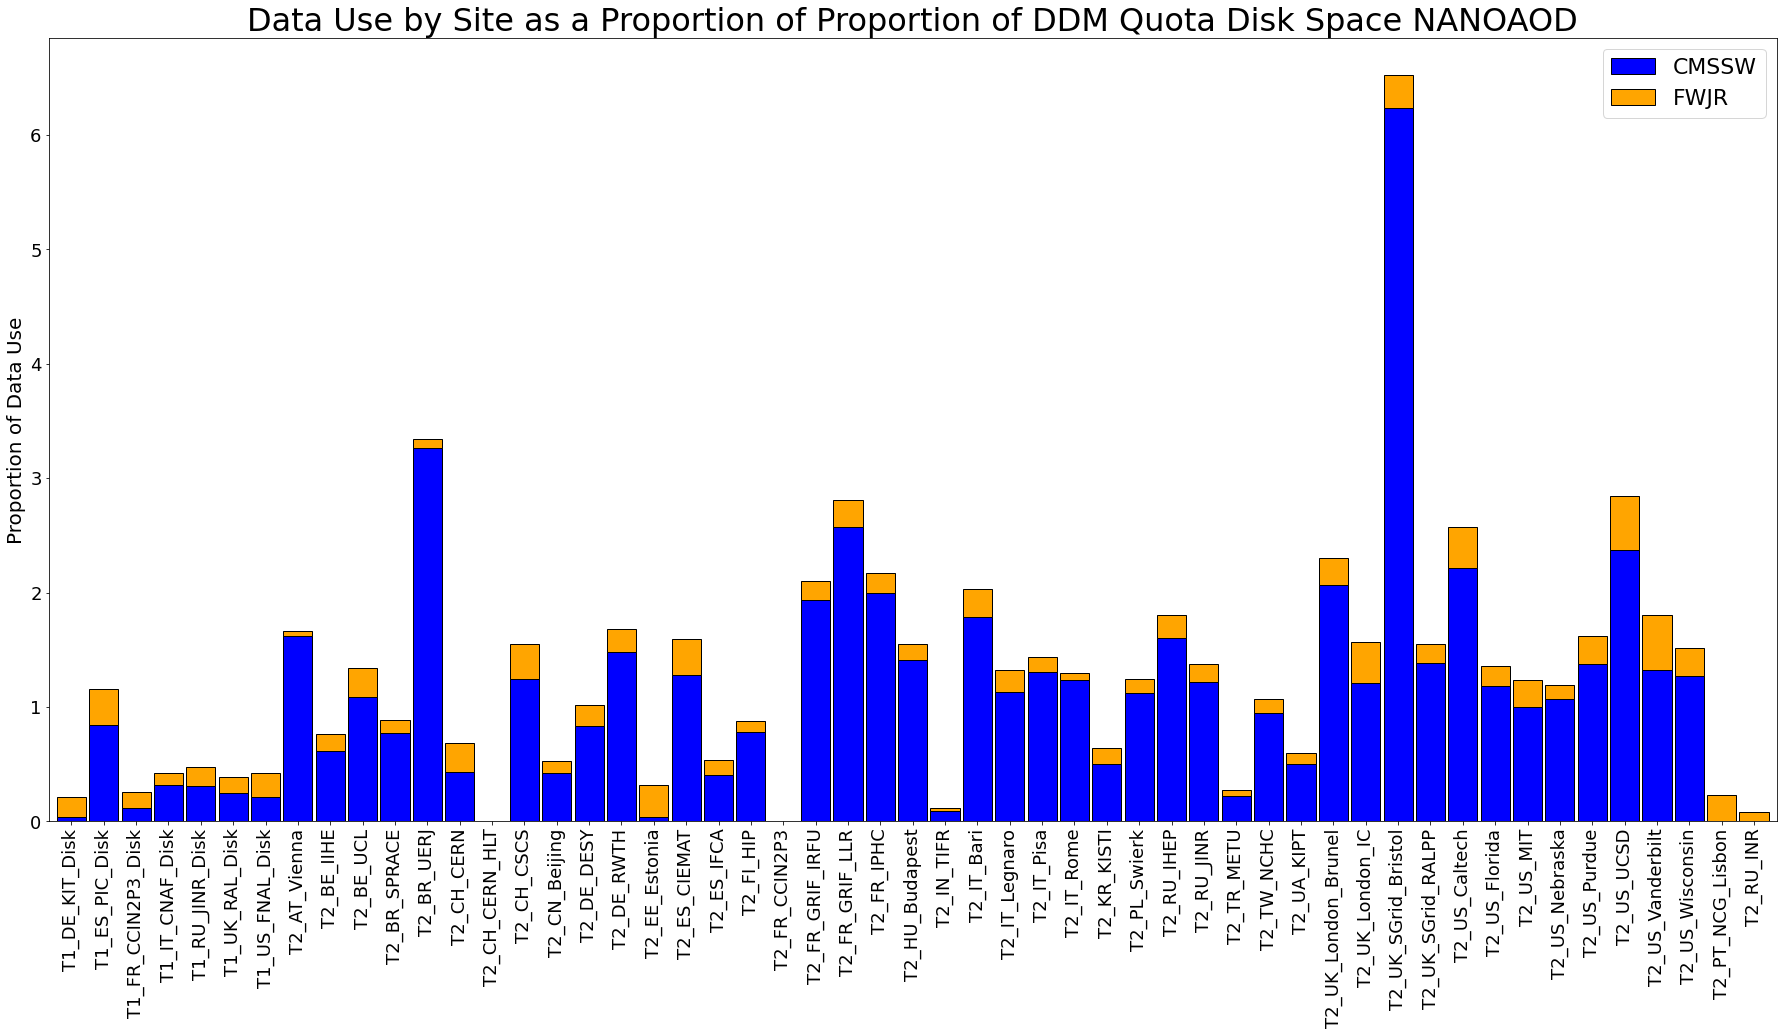

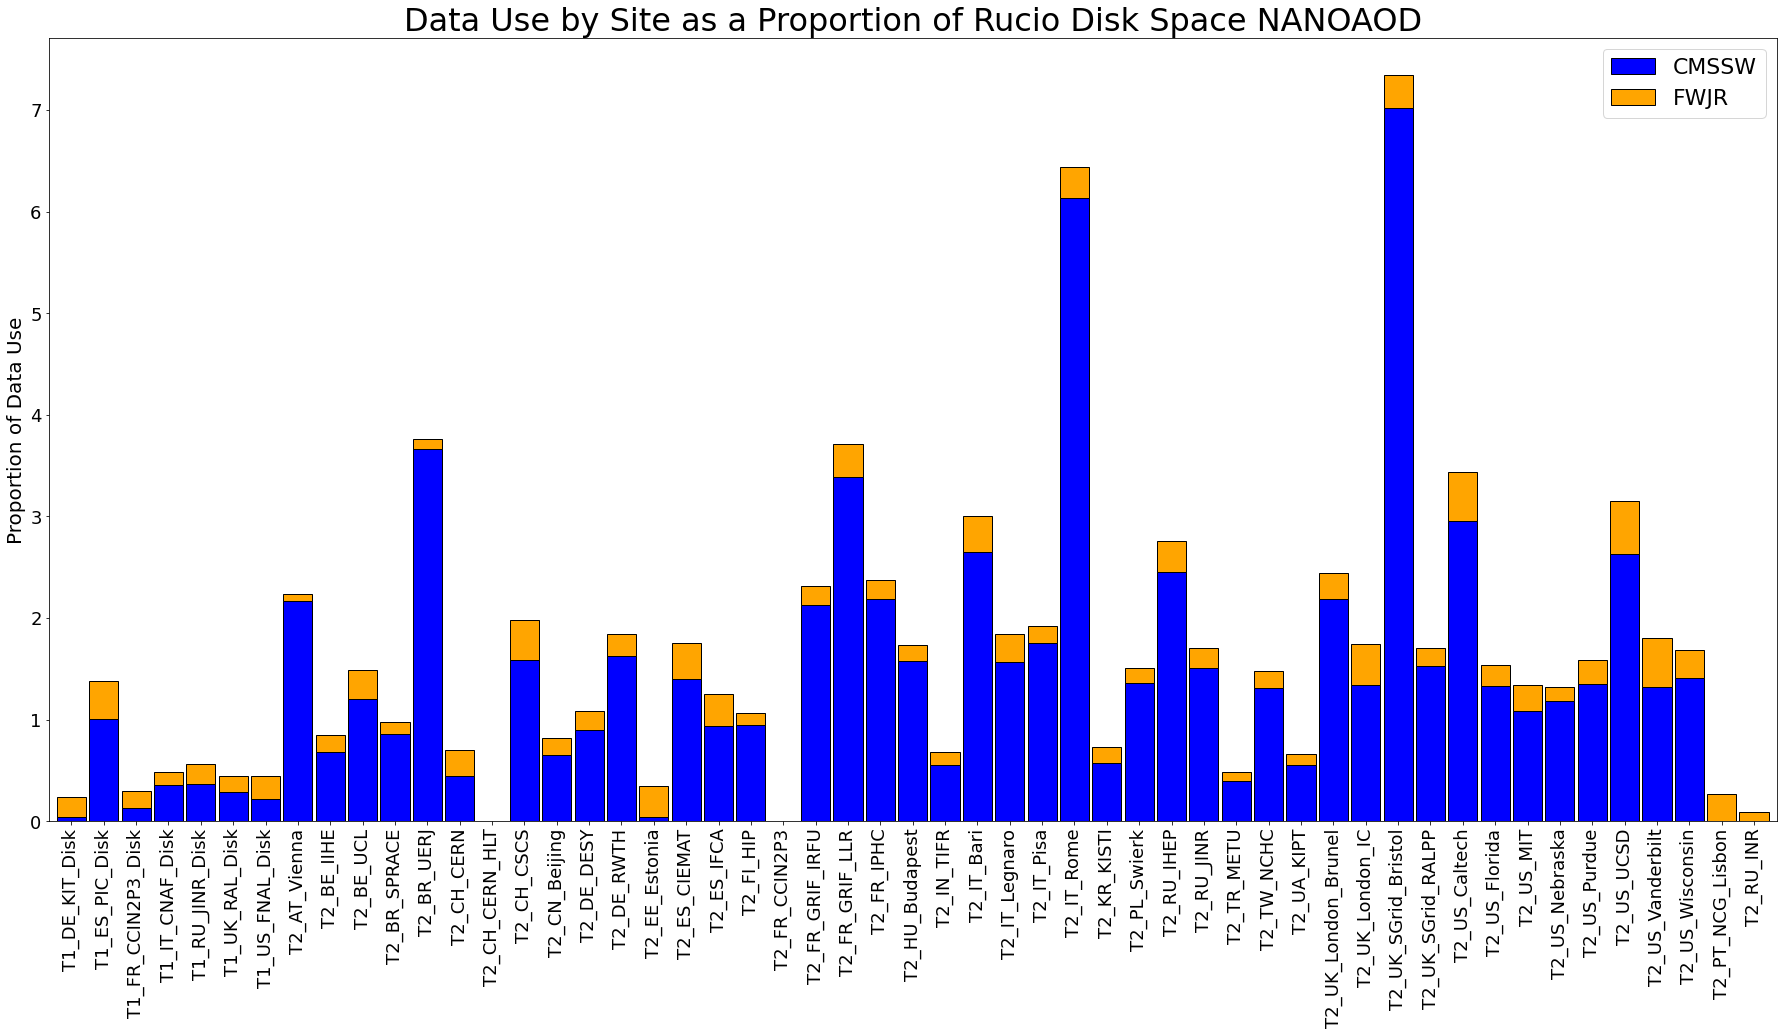

In [15]:
pp = PdfPages('plots/all_site_plots.pdf')

store = ['static', 'rucio']
title = ['Proportion of DDM Quota', 'Rucio']
var = ['', ' AOD', ' MINIAOD', ' NANOAOD']
suffix = ['', '_aod', '_mini', '_nano']    
    

for i, kind in enumerate(['', '_aod', '_mini', '_nano']):
    plot(kind, var[i], 'Data Use [PB]', True)
    for j, space in enumerate(['_stat', '_rucio']):
        globals()['full' + space + kind] = globals()['full' + kind].copy()
        globals()['full' + space + 
                  kind]['CMSSW'] = globals()['full' + 
                                             kind]['CMSSW'].divide(totals['used'][store[j]]
                                                                /1e15, fill_value=0).fillna(0).replace(np.inf, 0)
        
        globals()['full' + space + 
                  kind]['FWJR']= globals()['full'+ 
                                            kind]['FWJR'].divide(totals['used'][store[j]]
                                                              /1e15, fill_value=0).fillna(0).replace(np.inf, 0)

        plot(space + kind, ' as a Proportion of ' + title[j] + ' Disk Space' + var[i], 'Proportion of Data Use', True)

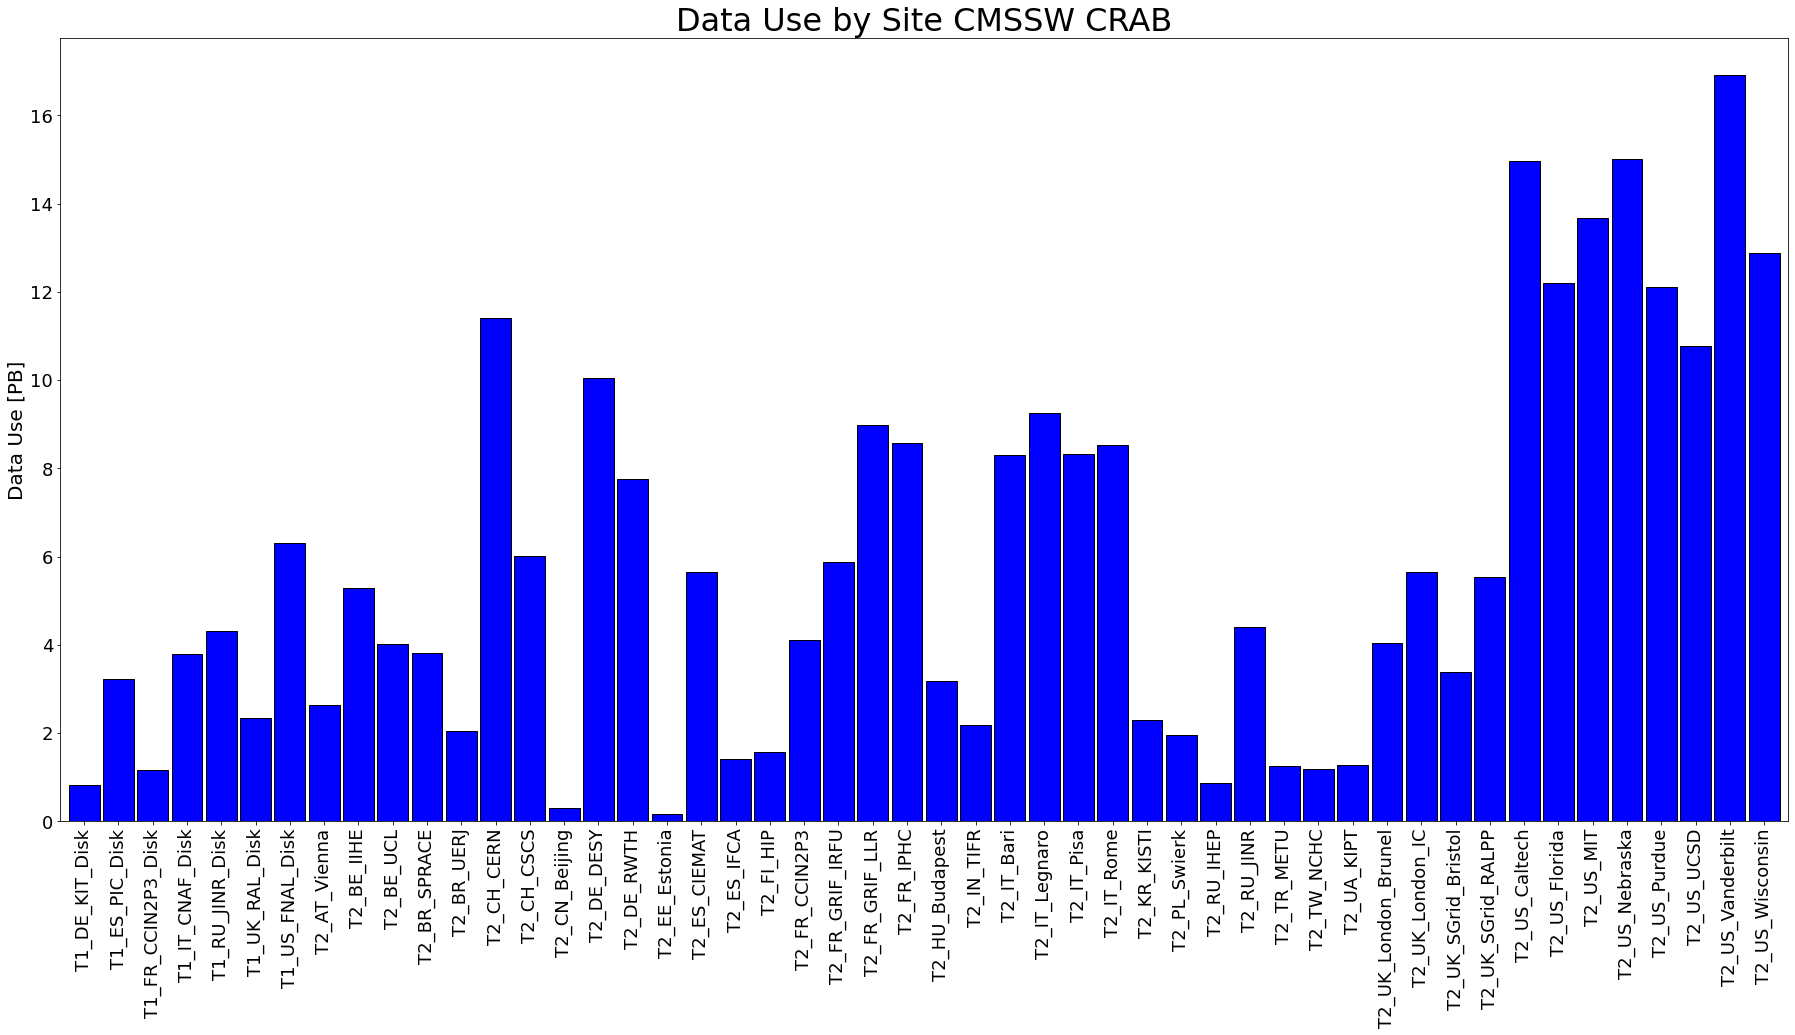

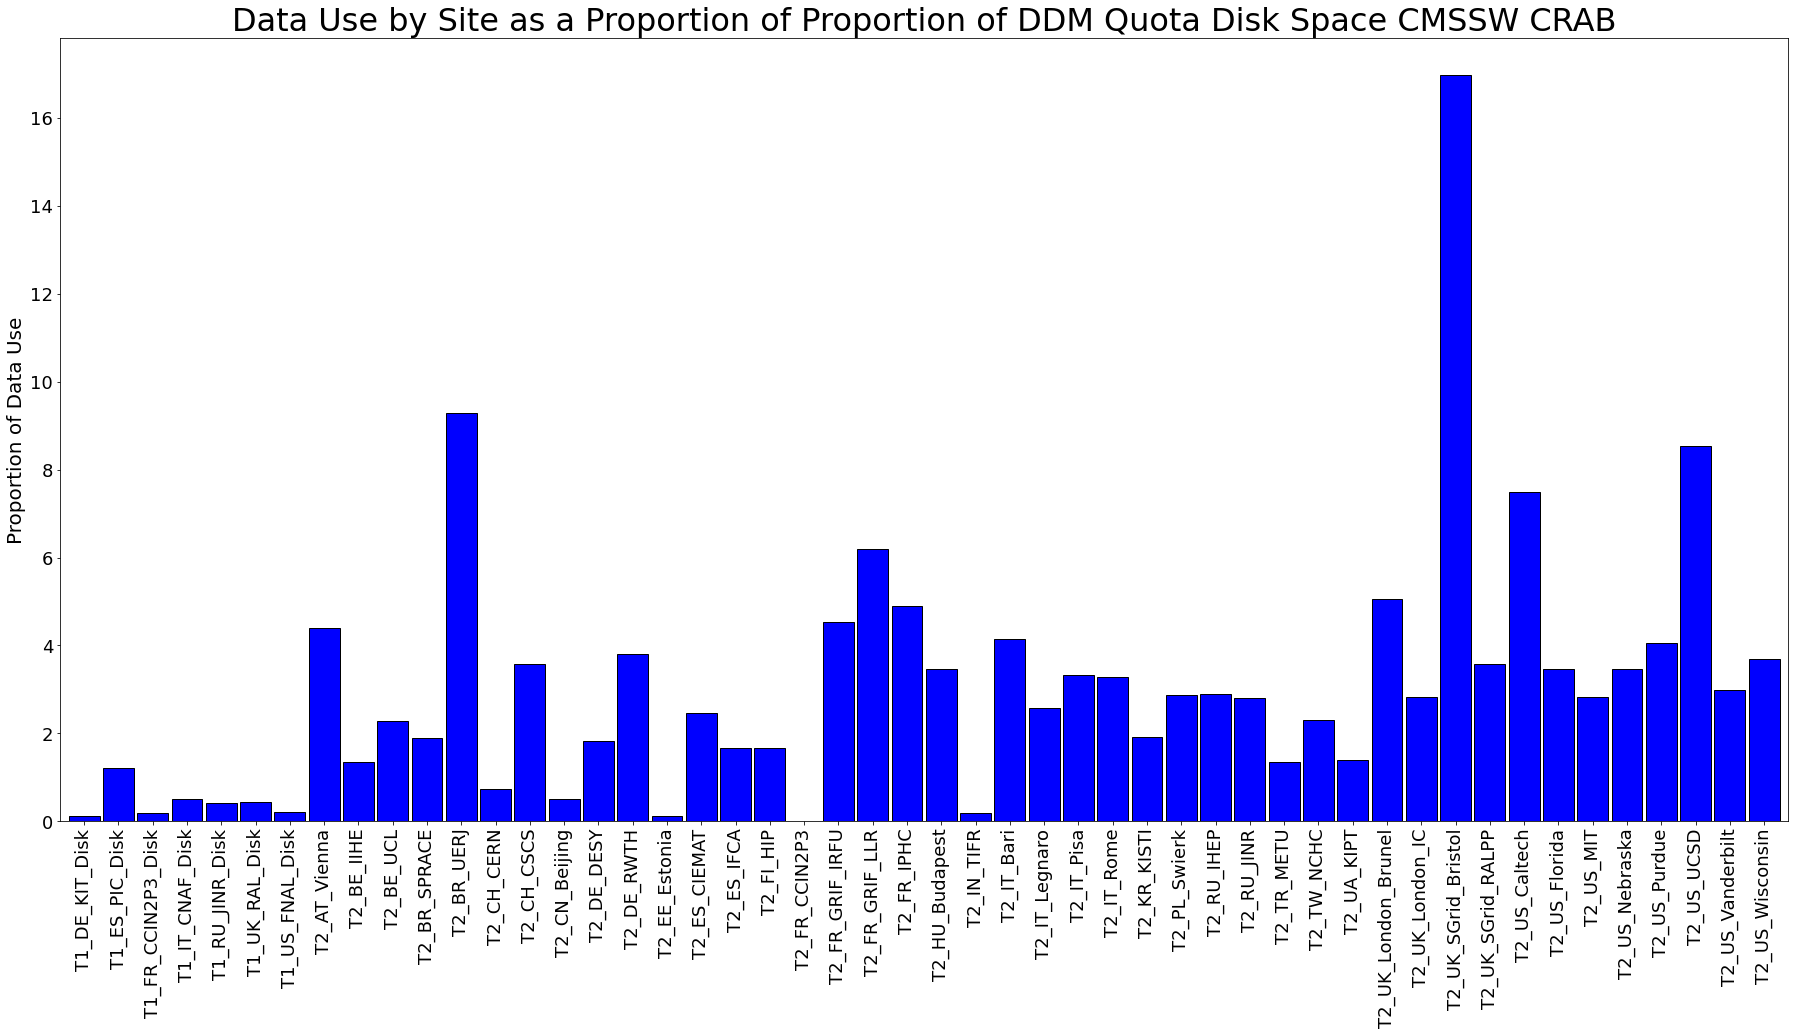

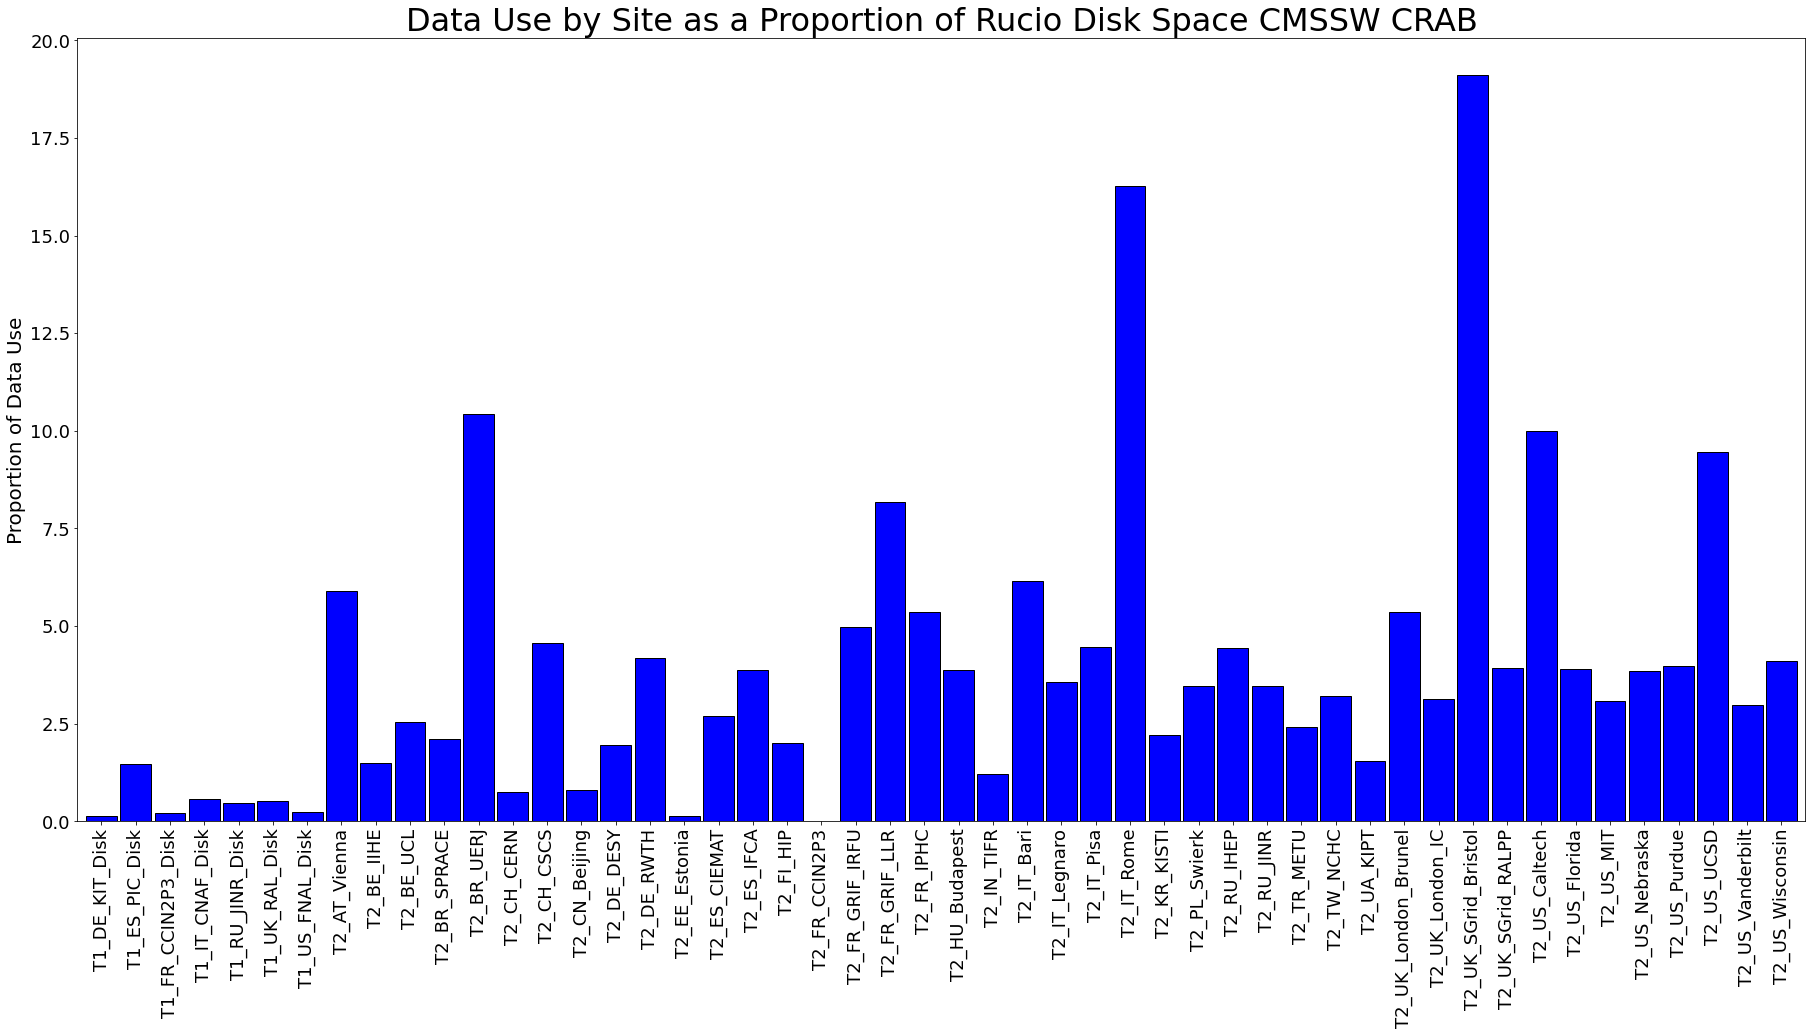

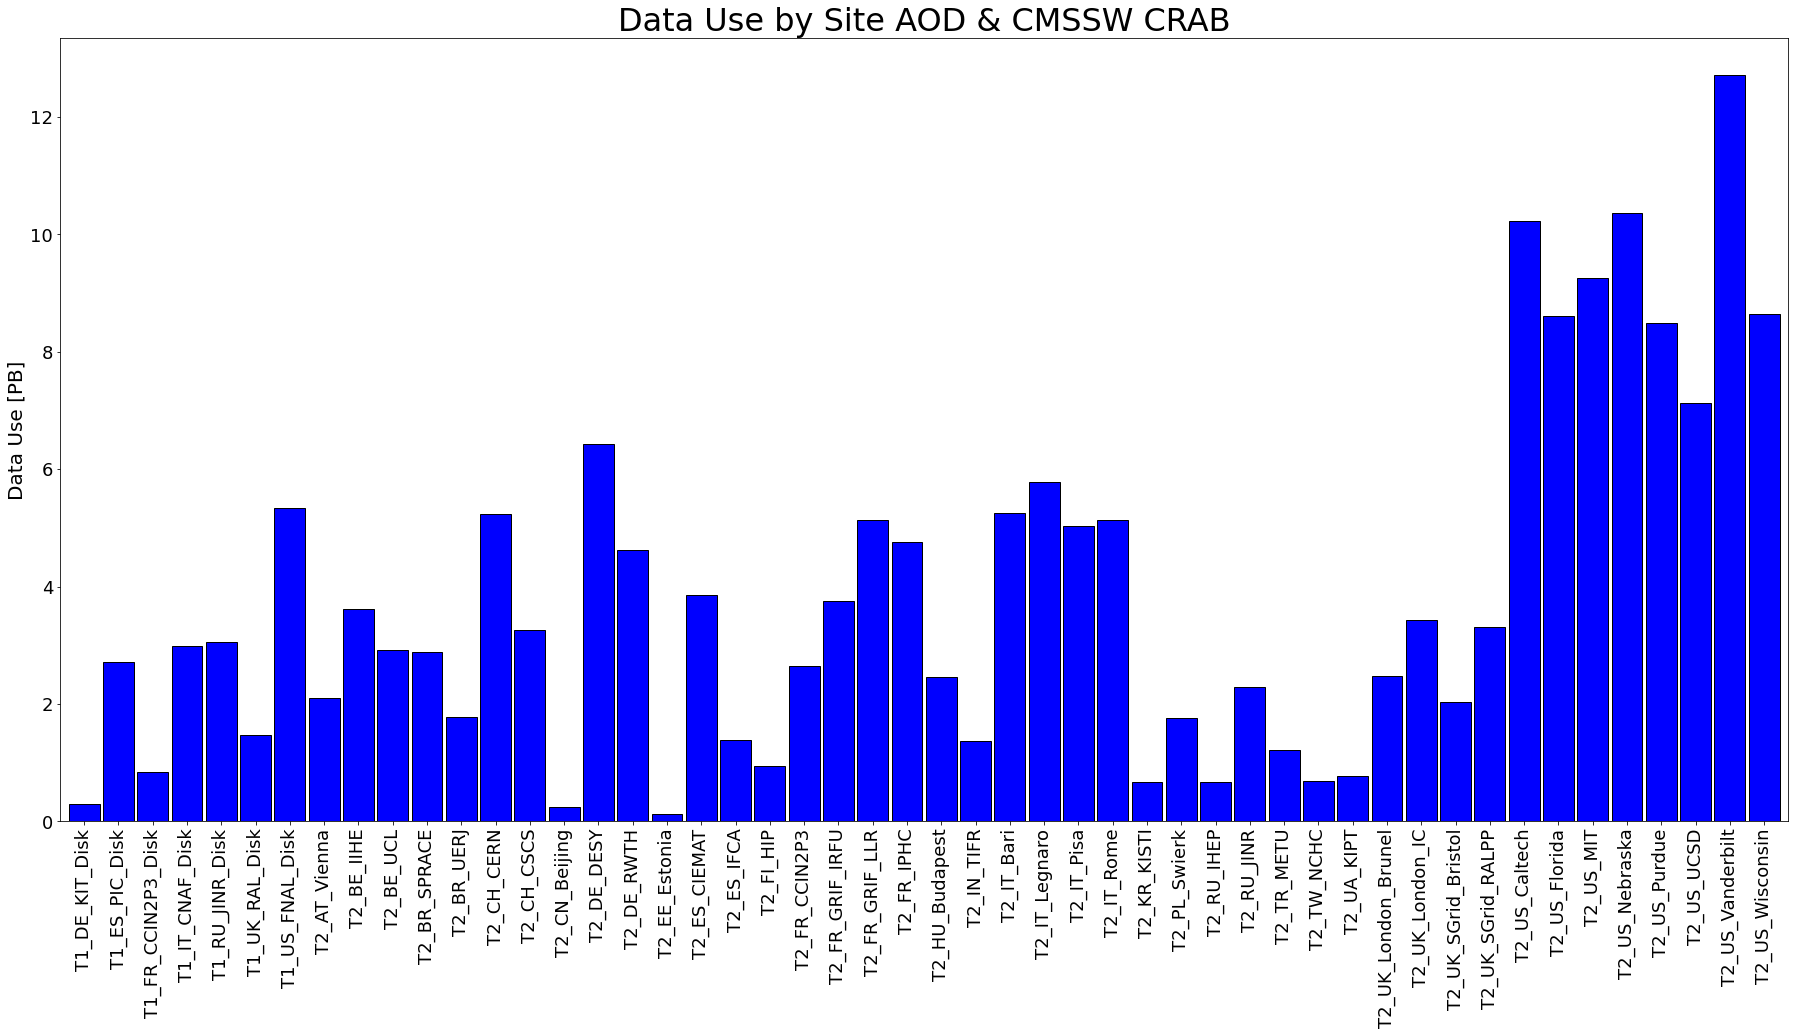

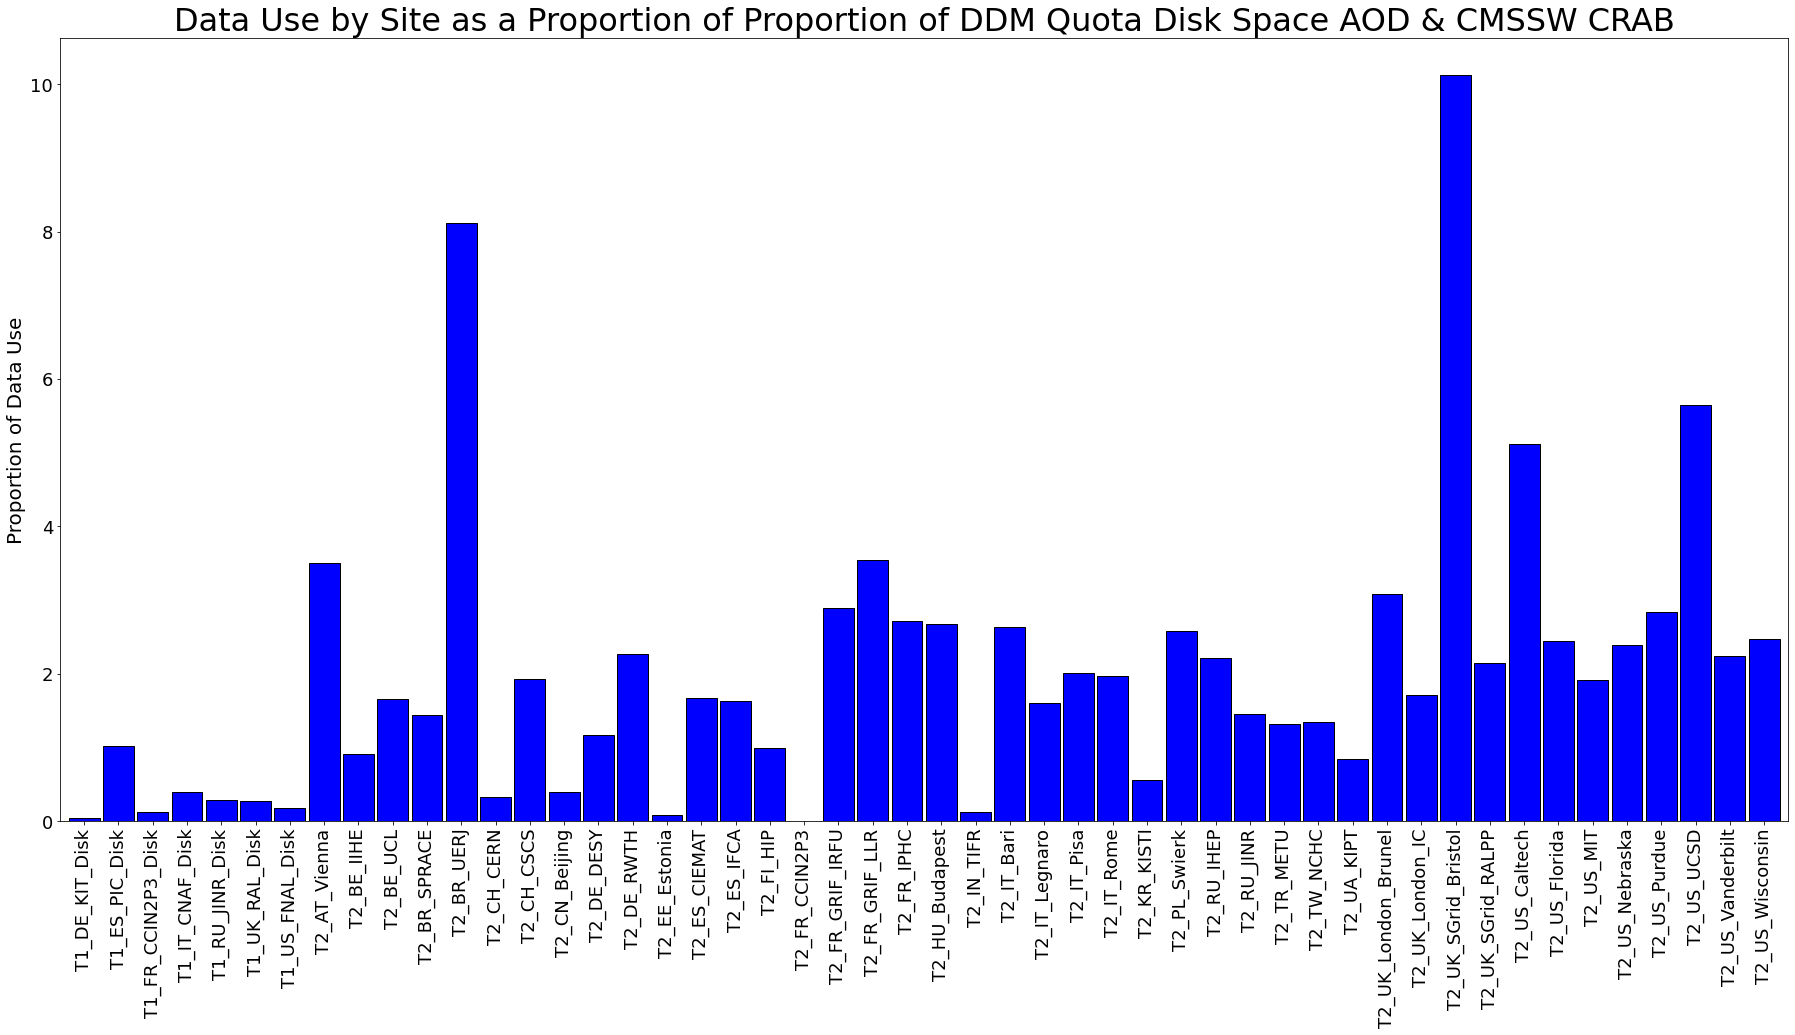

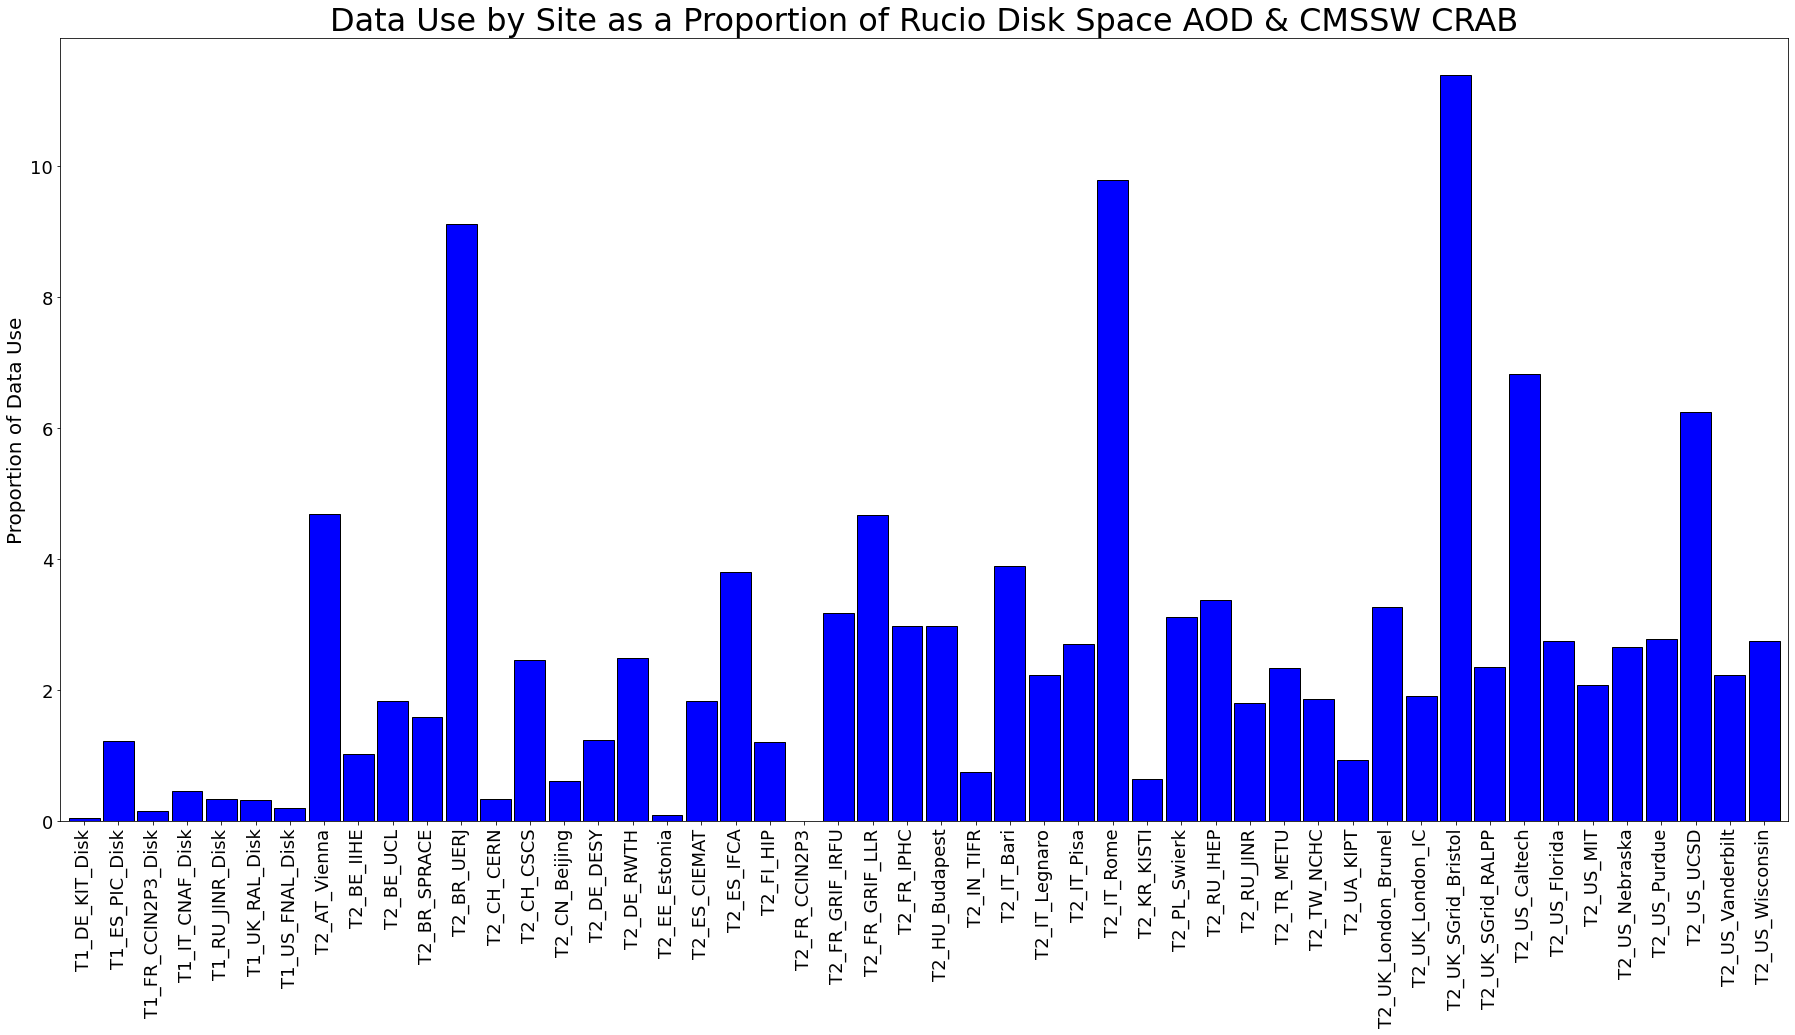

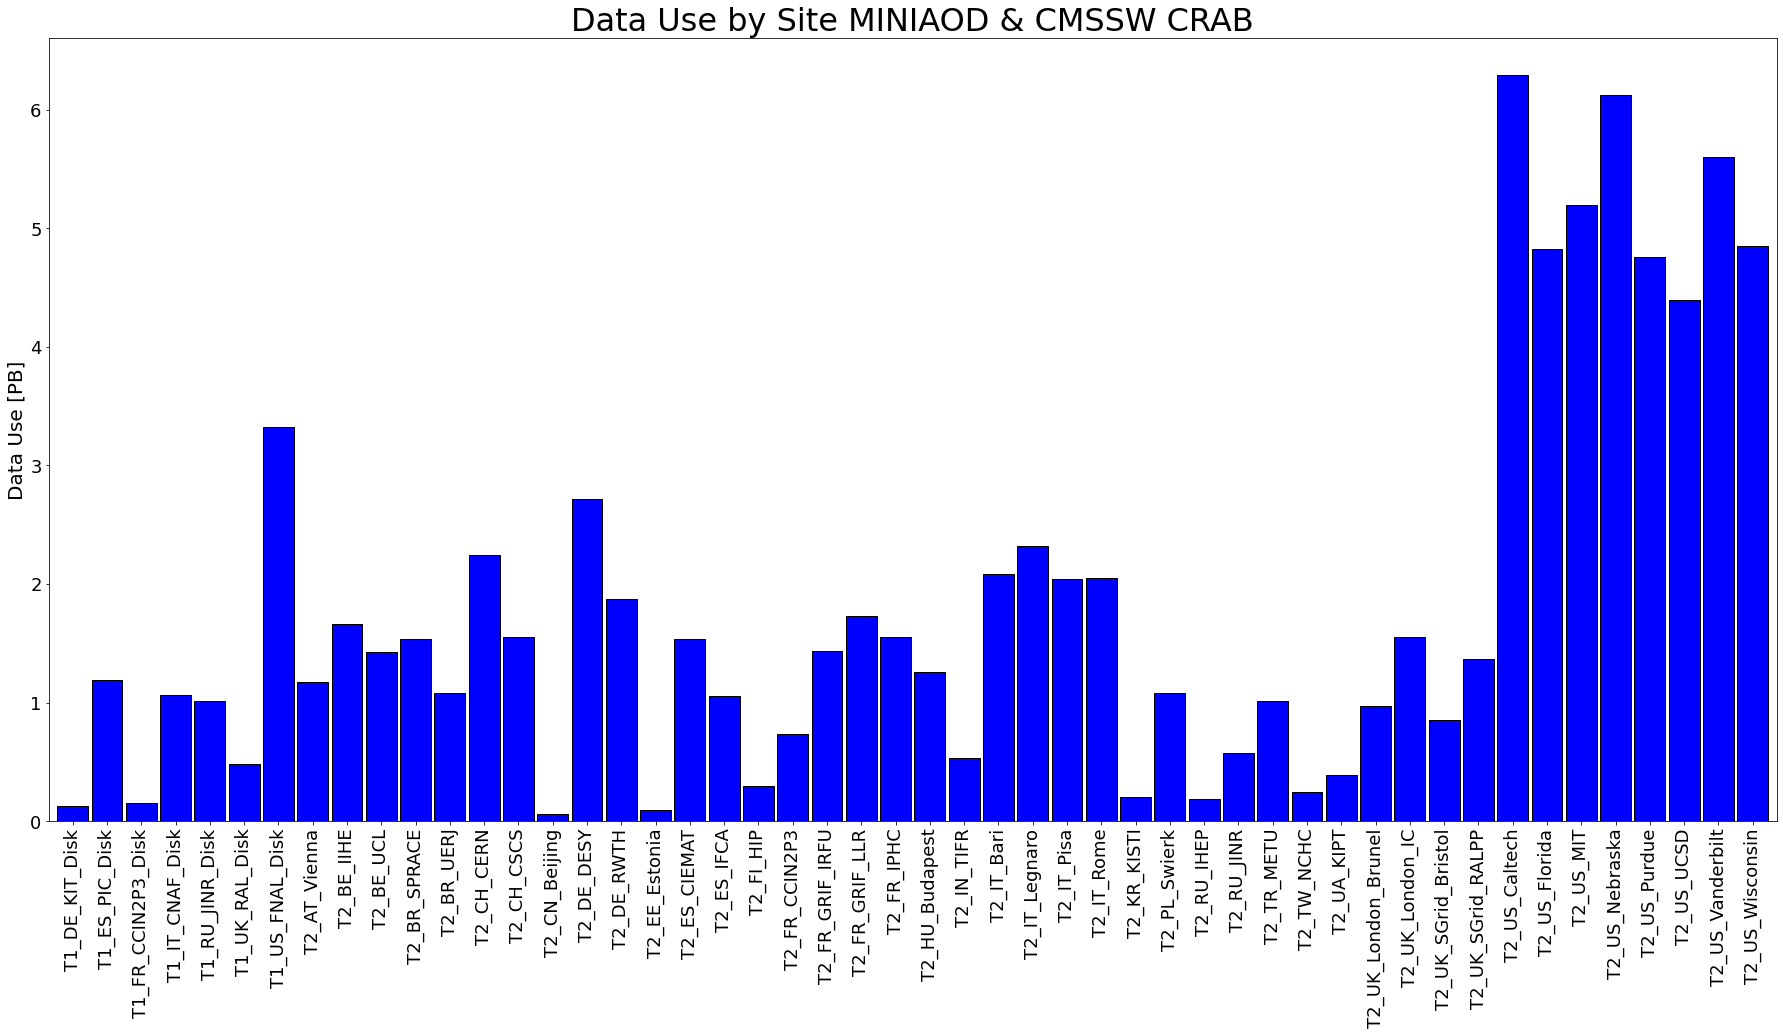

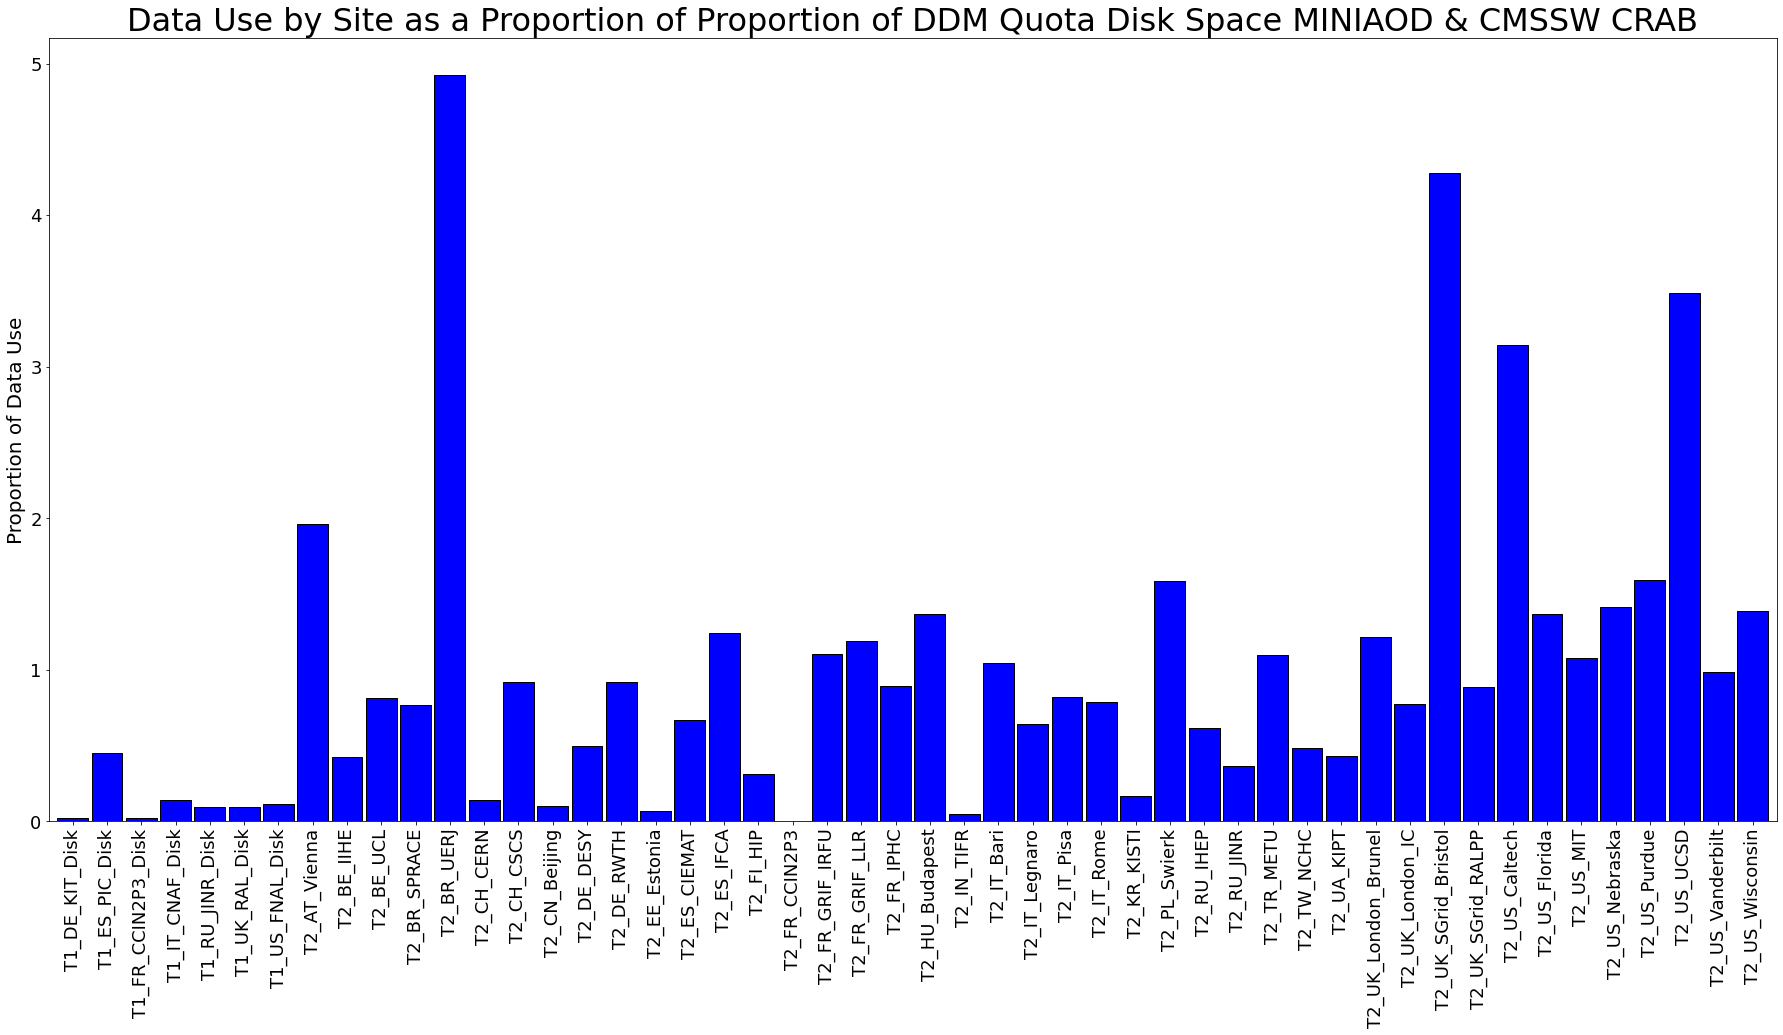

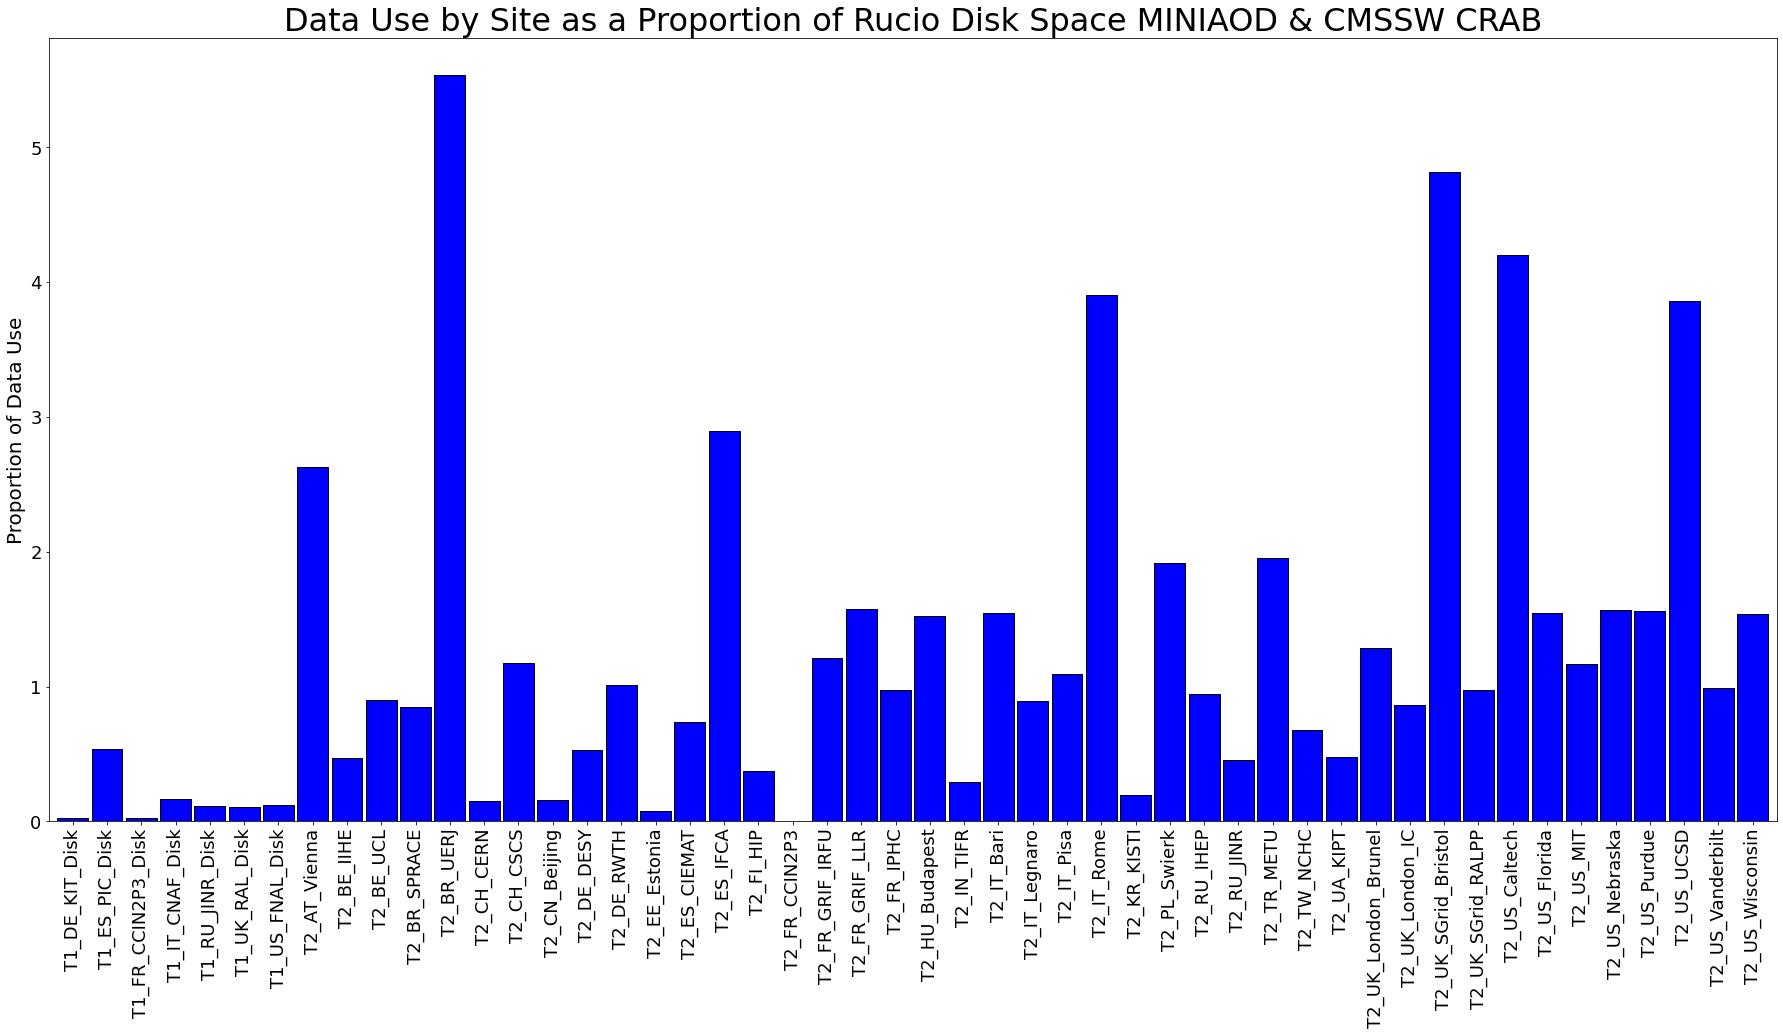

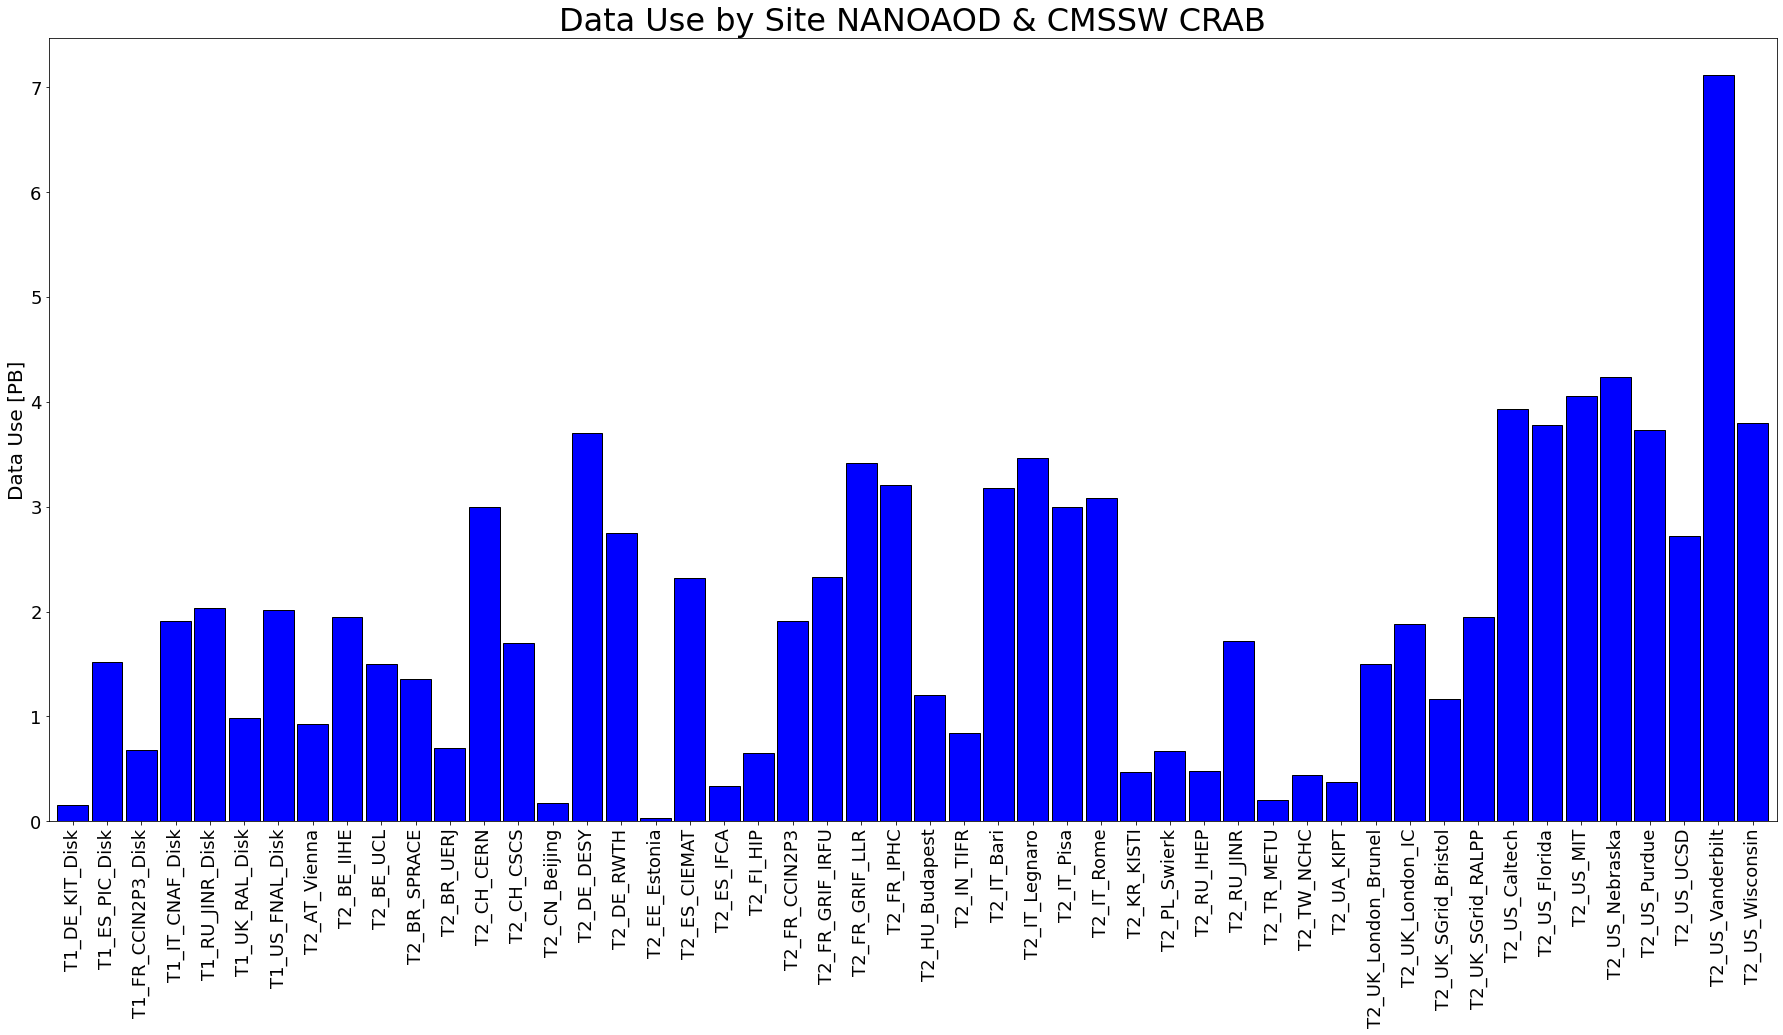

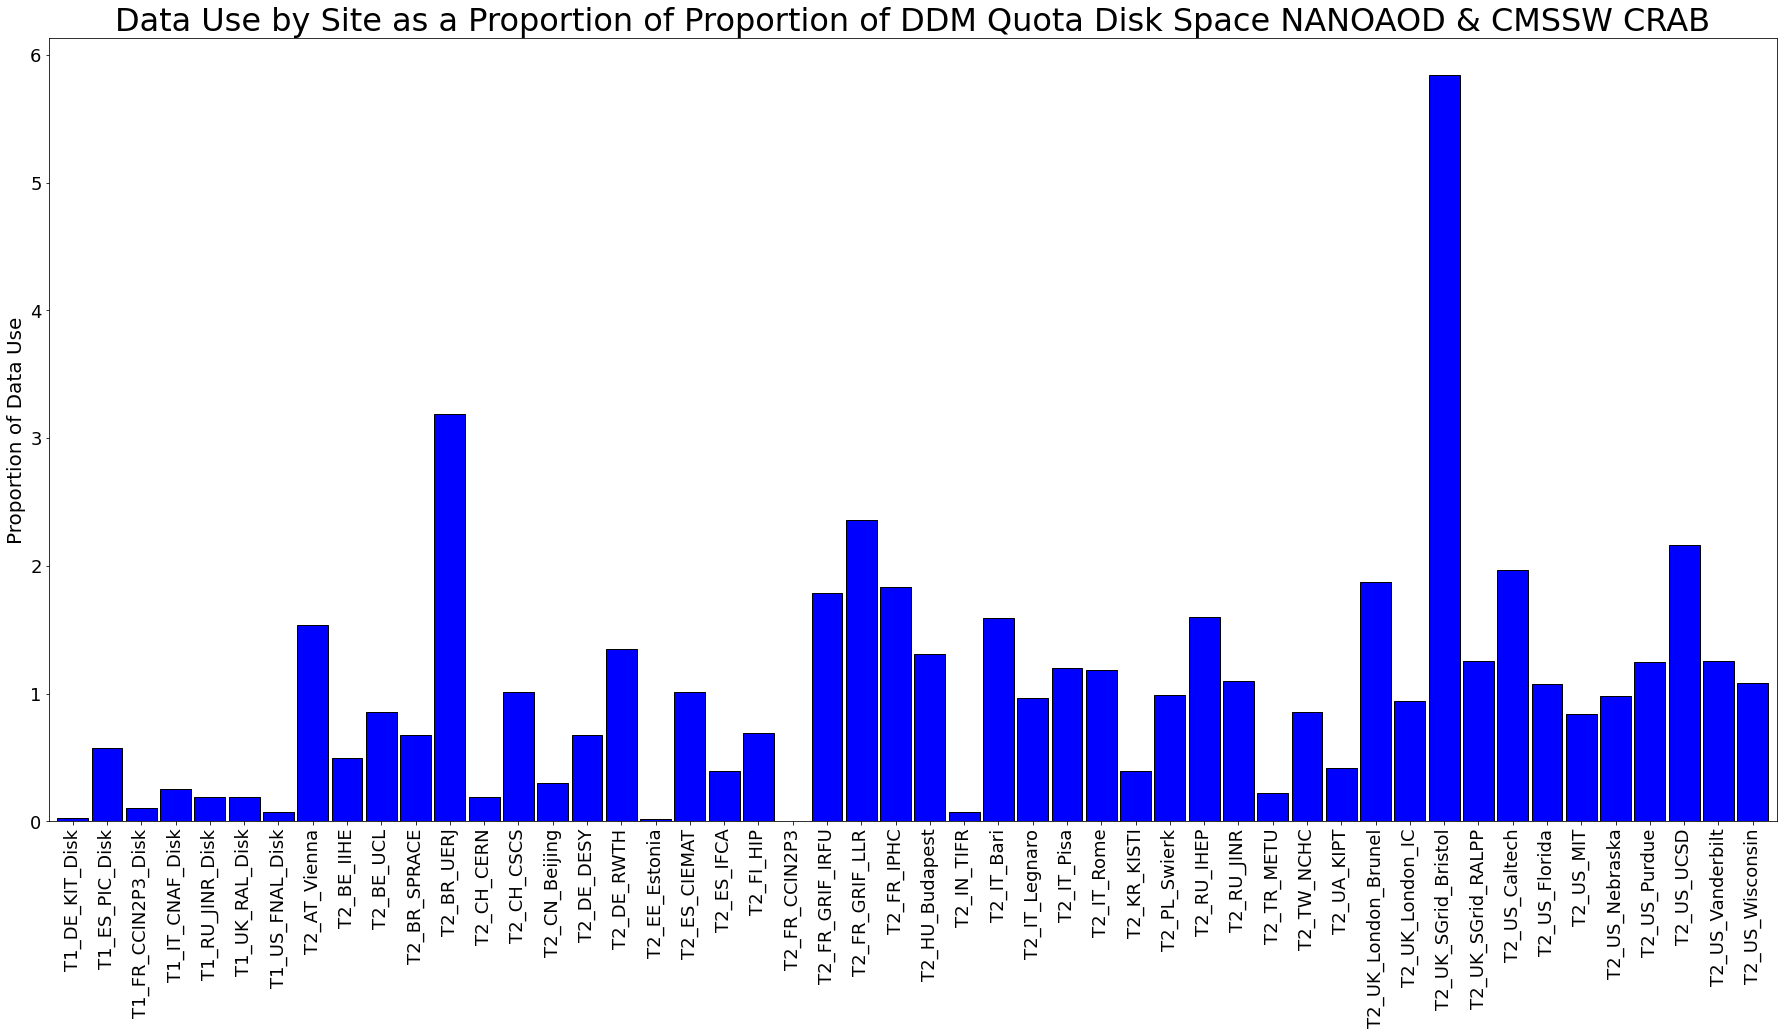

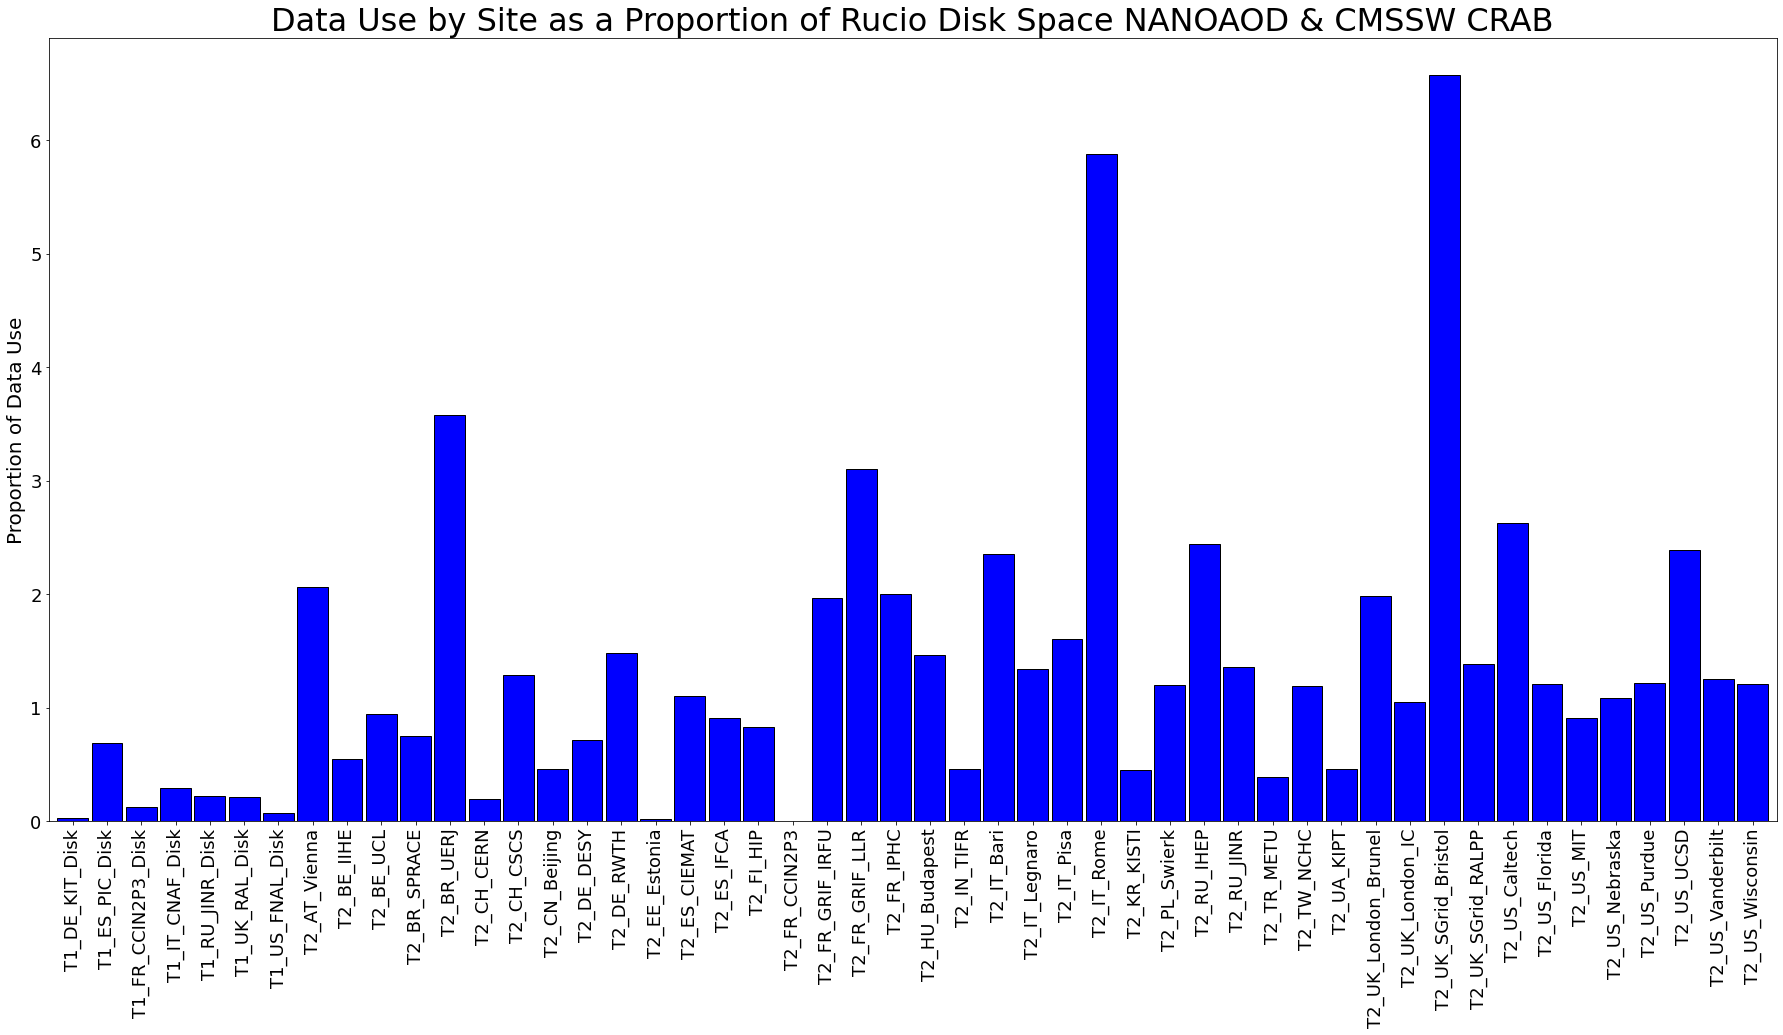

In [16]:
var = [' CMSSW CRAB', ' AOD & CMSSW CRAB',  ' MINIAOD & CMSSW CRAB', ' NANOAOD & CMSSW CRAB']
suffix = ['_crab', '_aod_crab', '_mini_crab', '_nano_crab']    

for i, kind in enumerate(['_crab', '_aod_crab', '_mini_crab', '_nano_crab']):
    plot(kind, var[i], 'Data Use [PB]', False)
    for j, space in enumerate(['_stat', '_rucio']):
        globals()['full' + space + kind] = globals()['full' + kind].copy()
        globals()['full' + space + 
                  kind]['CMSSW'] = globals()['full' + 
                                             kind]['CMSSW'].divide(totals['used'][store[j]]
                                                                /1e15, fill_value=0).fillna(0).replace(np.inf, 0)

        plot(space + kind, ' as a Proportion of ' + title[j] + ' Disk Space' + var[i], 'Proportion of Data Use', False)

pp.close()